# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


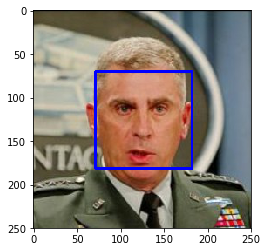

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
faces_in_humans_percent = len([img_file for img_file in human_files_short if face_detector(img_file)])/len(human_files_short) *100
print("Detected {} % of human faces in human_files_short".format(faces_in_humans_percent))
faces_in_dogs_percent = len([img_file for img_file in dog_files_short if face_detector(img_file)])/len(dog_files_short) * 100
print("Detected {} % of human faces in dog_files_short".format(faces_in_dogs_percent))


Detected 97.0 % of human faces in human_files_short
Detected 11.0 % of human faces in dog_files_short


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dogs_in_humans_percent = len([img_file for img_file in human_files_short if dog_detector(img_file)])/len(human_files_short) *100
print("Detected {} % of dogs in human_files_short".format(dogs_in_humans_percent))
dogs_in_dogs_percent = len([img_file for img_file in dog_files_short if dog_detector(img_file)])/len(dog_files_short) * 100
print("Detected {} % of dogs in dog_files_short".format(dogs_in_dogs_percent))

Detected 1.0 % of dogs in human_files_short
Detected 100.0 % of dogs in dog_files_short


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 143.18it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ I started with the architecture from the tutorial on MNIST, just adapting the input shape and the output layer with softmax for the 133 breed. this gave me around 9% with 5 epochs on my cpu. I then tried training on aws gpu with different epochs.

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=2, padding='same', input_shape=train_tensors.shape[1:], activation='relu'))
model.add(MaxPooling2D(pool_size=2))
          
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))     
          
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))      

model.add(Flatten())        
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [15]:
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5
batch_size = 16
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

%time model.fit(train_tensors, train_targets, \
          validation_data=(valid_tensors, valid_targets), \
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 11s - loss: 4.8682 - acc: 0.0175 - val_loss: 4.6182 - val_acc: 0.0455
Epoch 2/5
6680/6680 [==============================] - 10s - loss: 4.4143 - acc: 0.0536 - val_loss: 4.4742 - val_acc: 0.0587
Epoch 3/5
6680/6680 [==============================] - 10s - loss: 3.8145 - acc: 0.1380 - val_loss: 4.2370 - val_acc: 0.0719
Epoch 4/5
6680/6680 [==============================] - 10s - loss: 2.8543 - acc: 0.3172 - val_loss: 4.2926 - val_acc: 0.0970
Epoch 5/5
6680/6680 [==============================] - 10s - loss: 1.7545 - acc: 0.5626 - val_loss: 5.0961 - val_acc: 0.0719
CPU times: user 41.8 s, sys: 4.44 s, total: 46.3 s
Wall time: 52.3 s


In [16]:
##trying data augmentation on the fly using loaded tensors
epochs = 5
batch_size = 16
train_datagen = ImageDataGenerator(
        #rescale=1./255,
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=45,
        width_shift_range=.1,
        height_shift_range=.1,
        shear_range=0.2,
        zoom_range=0.2,
        channel_shift_range=0,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False)

valid_datagen = ImageDataGenerator(
        #rescale=1./255
)

train_generator = train_datagen.flow(
        train_tensors,
        train_targets,
        batch_size=batch_size)

validation_generator = valid_datagen.flow(
        valid_tensors, 
        valid_targets,
        batch_size=batch_size)

checkpointerDataAugmented = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_augmented.hdf5', 
                               verbose=1, save_best_only=True)

%time model.fit_generator( \
        train_generator, \
        steps_per_epoch=train_tensors.shape[0]//batch_size, \
        epochs=epochs, \
        validation_data=validation_generator, \
        validation_steps=valid_tensors.shape[0]//batch_size, \
        callbacks=[checkpointerDataAugmented], verbose=1)

Epoch 1/5
417/417 [==============================] - 51s - loss: 4.2705 - acc: 0.0719 - val_loss: 4.0643 - val_acc: 0.0877
Epoch 2/5
417/417 [==============================] - 50s - loss: 4.1131 - acc: 0.0853 - val_loss: 4.0097 - val_acc: 0.0769
Epoch 3/5
417/417 [==============================] - 50s - loss: 4.0384 - acc: 0.0931 - val_loss: 3.9121 - val_acc: 0.1001
Epoch 4/5
417/417 [==============================] - 50s - loss: 3.9628 - acc: 0.1076 - val_loss: 3.8744 - val_acc: 0.1221
Epoch 5/5
417/417 [==============================] - 50s - loss: 3.9271 - acc: 0.1108 - val_loss: 3.9143 - val_acc: 0.1172
CPU times: user 4min 46s, sys: 12.5 s, total: 4min 58s
Wall time: 4min 13s


In [17]:
#augment the dataset aggressively and save on disk
runThisCell=False #disabled
if runThisCell:
    import os
    import multiprocessing
    import tools.image as T

    global pool
    try:
        pool.terminate()
    except:
        pass


    pool = multiprocessing.Pool(processes=8)

    train_datagen = T.ImageDataGenerator(
            rescale=1./255,
            featurewise_center=False,
            samplewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            zca_whitening=False,
            rotation_range=45,
            width_shift_range=.1,
            height_shift_range=.1,
            shear_range=0.2,
            zoom_range=0.2,
            channel_shift_range=0,
            fill_mode='nearest',
            cval=0.,
            horizontal_flip=True,
            vertical_flip=False,
            pool=pool)

    training_root="dogImages/train"
    training_augmented_root="dogImages/train_augmented"
    if not os.path.exists(training_augmented_root):
        os.makedirs(training_augmented_root)

    for cat in next(os.walk(training_root))[1]:
        cat_dir = os.path.join(training_root,cat)
        augmented_dir=os.path.join(training_augmented_root,cat)
        if not os.path.exists(augmented_dir):
            os.makedirs(augmented_dir)
        for img in os.listdir(cat_dir):
            img_path=os.path.join(cat_dir,img)
            x = img_to_array(load_img(img_path))
            x = x.reshape((1,) + x.shape)
            i = 0
            for batch in train_datagen.flow(x, batch_size=1,
                              save_to_dir=augmented_dir, save_format='jpeg'):
                i += 1
                if i > 100: #x100 data set size
                    break  

In [ ]:
runThisCell=True #disabled
if runThisCell:
    train_files_augmented, train_targets_augmented = load_dataset('dogImages/train_augmented')

In [ ]:
import queue
import threading

#experimenting with longer training with augmented dataset
epochs = 5
batch_size = 512

checkpointerDataAugmentedDisk = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_augmented_disk.hdf5', 
                               verbose=1, save_best_only=True)


tensors_queue = queue.Queue()

def createTensors(chunk_train_files, chunk_train_targets, q):
    
    q.put((paths_to_tensor(chunk_train_files).astype('float32')/255,chunk_train_targets))

def train(q):
    chunk_train_tensors,chunk_train_targets = q.get()
    %time model.fit(chunk_train_tensors, chunk_train_targets, \
          validation_data=(valid_tensors, valid_targets), \
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointerDataAugmentedDisk])

    
chunk_size=30000
index=0
train_set_size=len(train_files_augmented)
last=min(index+chunk_size,train_set_size-1)
chunk_train_files=train_files_augmented[index:last]
chunk_train_targets=train_targets_augmented[index:last]
index+=chunk_size

loader = threading.Thread(target=createTensors, args=(chunk_train_files,chunk_train_targets,tensors_queue))
loader.setDaemon(True)
loader.start()

while index<train_set_size:
    
    loader.join()
    trainer= threading.Thread(target=train, args=(tensors_queue,))
    trainer.setDaemon(True)
    trainer.start()
    
    last=min(index+chunk_size,train_set_size-1)
    chunk_train_files=train_files_augmented[index:last]
    chunk_train_targets=train_targets_augmented[index:last]
    index+=chunk_size

    loader = threading.Thread(target=createTensors, args=(chunk_train_files,chunk_train_targets,tensors_queue))
    loader.setDaemon(True)
    loader.start()
    trainer.join()
    
    
    
tensors_queue.join()    
    
    

  0%|          | 14/30000 [00:00<03:42, 134.80it/s]

Train on 30000 samples, validate on 835 samples
Epoch 1/5


  0%|          | 66/30000 [00:00<05:30, 90.68it/s] 

  512/30000 [..............................] - ETA: 43s - loss: 3.9189 - acc: 0.1211

  0%|          | 95/30000 [00:00<04:30, 110.72it/s]

 1024/30000 [>.............................] - ETA: 32s - loss: 3.8249 - acc: 0.1318

  0%|          | 144/30000 [00:01<05:28, 90.79it/s]

 1536/30000 [>.............................] - ETA: 27s - loss: 3.8037 - acc: 0.1348

  1%|          | 181/30000 [00:01<05:14, 94.86it/s] 

 2048/30000 [=>............................] - ETA: 25s - loss: 3.7672 - acc: 0.1377

  1%|          | 221/30000 [00:02<05:05, 97.37it/s]

 2560/30000 [=>............................] - ETA: 24s - loss: 3.7131 - acc: 0.1457

  1%|          | 250/30000 [00:02<05:53, 84.10it/s] 

 3072/30000 [==>...........................] - ETA: 23s - loss: 3.7140 - acc: 0.1439

  1%|          | 292/30000 [00:03<05:43, 86.53it/s]

 3584/30000 [==>...........................] - ETA: 22s - loss: 3.7043 - acc: 0.1437

  1%|          | 335/30000 [00:03<04:59, 99.10it/s]

 4096/30000 [===>..........................] - ETA: 22s - loss: 3.6829 - acc: 0.1475

  1%|▏         | 376/30000 [00:03<04:21, 113.20it/s]

 4608/30000 [===>..........................] - ETA: 21s - loss: 3.6774 - acc: 0.1495

  1%|▏         | 401/30000 [00:04<04:49, 102.12it/s]

 5120/30000 [====>.........................] - ETA: 20s - loss: 3.6761 - acc: 0.1455

  1%|▏         | 426/30000 [00:04<04:59, 98.67it/s] 

 5632/30000 [====>.........................] - ETA: 20s - loss: 3.6770 - acc: 0.1428

  2%|▏         | 451/30000 [00:04<07:40, 64.17it/s]

 6144/30000 [=====>........................] - ETA: 19s - loss: 3.6768 - acc: 0.1434

  2%|▏         | 488/30000 [00:05<06:11, 79.52it/s]

 6656/30000 [=====>........................] - ETA: 18s - loss: 3.6684 - acc: 0.1453

  2%|▏         | 526/30000 [00:05<05:24, 90.87it/s]

 7168/30000 [======>.......................] - ETA: 18s - loss: 3.6623 - acc: 0.1459

  2%|▏         | 564/30000 [00:06<05:50, 84.06it/s]

 7680/30000 [======>.......................] - ETA: 17s - loss: 3.6593 - acc: 0.1445

  2%|▏         | 599/30000 [00:06<04:54, 99.68it/s]

 8192/30000 [=======>......................] - ETA: 17s - loss: 3.6580 - acc: 0.1459

  2%|▏         | 654/30000 [00:06<04:17, 113.92it/s]

 8704/30000 [=======>......................] - ETA: 16s - loss: 3.6653 - acc: 0.1452

  2%|▏         | 692/30000 [00:07<04:15, 114.92it/s]

 9216/30000 [========>.....................] - ETA: 16s - loss: 3.6626 - acc: 0.1453

  2%|▏         | 728/30000 [00:07<03:49, 127.38it/s]

 9728/30000 [========>.....................] - ETA: 16s - loss: 3.6635 - acc: 0.1441

  3%|▎         | 782/30000 [00:08<04:31, 107.74it/s]

10240/30000 [=========>....................] - ETA: 15s - loss: 3.6601 - acc: 0.1433

  3%|▎         | 826/30000 [00:08<03:51, 126.18it/s]

10752/30000 [=========>....................] - ETA: 15s - loss: 3.6559 - acc: 0.1426

  3%|▎         | 866/30000 [00:08<04:41, 103.64it/s]

11264/30000 [==========>...................] - ETA: 14s - loss: 3.6531 - acc: 0.1427

  3%|▎         | 898/30000 [00:09<04:58, 97.49it/s] 

11776/30000 [==========>...................] - ETA: 14s - loss: 3.6547 - acc: 0.1433

  3%|▎         | 944/30000 [00:09<03:54, 123.77it/s]

12288/30000 [===========>..................] - ETA: 13s - loss: 3.6509 - acc: 0.1440

  3%|▎         | 983/30000 [00:09<05:09, 93.83it/s] 

12800/30000 [===========>..................] - ETA: 13s - loss: 3.6472 - acc: 0.1448

  3%|▎         | 1023/30000 [00:10<04:27, 108.39it/s]

13312/30000 [============>.................] - ETA: 12s - loss: 3.6412 - acc: 0.1453

  4%|▎         | 1062/30000 [00:10<05:45, 83.87it/s] 

13824/30000 [============>.................] - ETA: 12s - loss: 3.6364 - acc: 0.1467

  4%|▎         | 1092/30000 [00:11<05:30, 87.51it/s]

14336/30000 [=============>................] - ETA: 12s - loss: 3.6337 - acc: 0.1460

  4%|▍         | 1137/30000 [00:11<04:24, 109.16it/s]

14848/30000 [=============>................] - ETA: 11s - loss: 3.6346 - acc: 0.1450

  4%|▍         | 1173/30000 [00:11<05:06, 94.08it/s] 

15360/30000 [==============>...............] - ETA: 11s - loss: 3.6320 - acc: 0.1453

  4%|▍         | 1227/30000 [00:12<03:59, 120.24it/s]

15872/30000 [==============>...............] - ETA: 10s - loss: 3.6287 - acc: 0.1456

  4%|▍         | 1276/30000 [00:12<03:26, 139.06it/s]

16384/30000 [===============>..............] - ETA: 10s - loss: 3.6208 - acc: 0.1475

  4%|▍         | 1320/30000 [00:12<03:55, 121.94it/s]

16896/30000 [===============>..............] - ETA: 10s - loss: 3.6202 - acc: 0.1475

  4%|▍         | 1333/30000 [00:13<04:43, 101.00it/s]

17408/30000 [================>.............] - ETA: 9s - loss: 3.6192 - acc: 0.1478 

  5%|▍         | 1362/30000 [00:13<05:55, 80.55it/s] 

17920/30000 [================>.............] - ETA: 9s - loss: 3.6193 - acc: 0.1480

  5%|▍         | 1421/30000 [00:14<04:39, 102.33it/s]

18432/30000 [=================>............] - ETA: 8s - loss: 3.6151 - acc: 0.1489

  5%|▍         | 1448/30000 [00:14<04:42, 101.22it/s]

18944/30000 [=================>............] - ETA: 8s - loss: 3.6114 - acc: 0.1500

  5%|▍         | 1485/30000 [00:14<05:49, 81.59it/s] 

19456/30000 [==================>...........] - ETA: 8s - loss: 3.6075 - acc: 0.1507

  5%|▌         | 1525/30000 [00:15<04:47, 99.11it/s]

19968/30000 [==================>...........] - ETA: 7s - loss: 3.6085 - acc: 0.1505

  5%|▌         | 1564/30000 [00:15<04:52, 97.22it/s] 

20480/30000 [===================>..........] - ETA: 7s - loss: 3.6040 - acc: 0.1512

  5%|▌         | 1603/30000 [00:15<04:06, 115.09it/s]

20992/30000 [===================>..........] - ETA: 6s - loss: 3.6009 - acc: 0.1520

  6%|▌         | 1653/30000 [00:16<04:01, 117.43it/s]

21504/30000 [====================>.........] - ETA: 6s - loss: 3.5988 - acc: 0.1521

  6%|▌         | 1705/30000 [00:16<03:20, 140.94it/s]

22016/30000 [=====================>........] - ETA: 6s - loss: 3.5963 - acc: 0.1523

  6%|▌         | 1766/30000 [00:17<03:27, 135.86it/s]

22528/30000 [=====================>........] - ETA: 5s - loss: 3.5935 - acc: 0.1529

  6%|▌         | 1794/30000 [00:17<03:50, 122.32it/s]

23040/30000 [======================>.......] - ETA: 5s - loss: 3.5905 - acc: 0.1529

  6%|▌         | 1830/30000 [00:17<05:45, 81.55it/s] 

23552/30000 [======================>.......] - ETA: 4s - loss: 3.5883 - acc: 0.1534

  6%|▌         | 1854/30000 [00:18<06:44, 69.66it/s]

24064/30000 [=======================>......] - ETA: 4s - loss: 3.5856 - acc: 0.1531

  6%|▋         | 1882/30000 [00:18<05:07, 91.42it/s]

24576/30000 [=======================>......] - ETA: 4s - loss: 3.5841 - acc: 0.1535

  6%|▋         | 1920/30000 [00:18<05:09, 90.69it/s]

25088/30000 [========================>.....] - ETA: 3s - loss: 3.5792 - acc: 0.1541

  7%|▋         | 1982/30000 [00:19<03:35, 130.08it/s]

25600/30000 [========================>.....] - ETA: 3s - loss: 3.5752 - acc: 0.1553

  7%|▋         | 2014/30000 [00:19<05:00, 93.22it/s] 

26112/30000 [=========================>....] - ETA: 2s - loss: 3.5744 - acc: 0.1550

  7%|▋         | 2050/30000 [00:20<04:58, 93.65it/s]

26624/30000 [=========================>....] - ETA: 2s - loss: 3.5757 - acc: 0.1550

  7%|▋         | 2072/30000 [00:20<06:29, 71.79it/s]

27136/30000 [==========================>...] - ETA: 2s - loss: 3.5761 - acc: 0.1547

  7%|▋         | 2132/30000 [00:20<04:01, 115.53it/s]

27648/30000 [==========================>...] - ETA: 1s - loss: 3.5735 - acc: 0.1553

  7%|▋         | 2174/30000 [00:21<04:09, 111.32it/s]

28160/30000 [===========================>..] - ETA: 1s - loss: 3.5714 - acc: 0.1558

  7%|▋         | 2204/30000 [00:21<05:24, 85.69it/s] 

28672/30000 [===========================>..] - ETA: 1s - loss: 3.5669 - acc: 0.1565

  7%|▋         | 2228/30000 [00:22<05:36, 82.49it/s]

29184/30000 [============================>.] - ETA: 0s - loss: 3.5662 - acc: 0.1567

  8%|▊         | 2276/30000 [00:22<04:27, 103.56it/s]

29696/30000 [============================>.] - ETA: 0s - loss: 3.5654 - acc: 0.1569

  8%|▊         | 2383/30000 [00:23<05:04, 90.73it/s] 

Epoch 00000: val_loss improved from inf to 3.70345, saving model to saved_models/weights.best.from_scratch_augmented_disk.hdf5
30000/30000 [==============================] - 23s - loss: 3.5643 - acc: 0.1570 - val_loss: 3.7034 - val_acc: 0.1545

  8%|▊         | 2394/30000 [00:24<10:15, 44.87it/s]


Epoch 2/5


  8%|▊         | 2402/30000 [00:24<09:24, 48.87it/s]

  512/30000 [..............................] - ETA: 21s - loss: 3.3210 - acc: 0.2012

  8%|▊         | 2426/30000 [00:24<06:44, 68.22it/s]

 1024/30000 [>.............................] - ETA: 21s - loss: 3.3516 - acc: 0.2041

  8%|▊         | 2476/30000 [00:25<05:15, 87.33it/s]

 1536/30000 [>.............................] - ETA: 20s - loss: 3.3492 - acc: 0.2005

  8%|▊         | 2517/30000 [00:25<04:20, 105.67it/s]

 2048/30000 [=>............................] - ETA: 20s - loss: 3.3467 - acc: 0.2012

  8%|▊         | 2550/30000 [00:25<04:04, 112.07it/s]

 2560/30000 [=>............................] - ETA: 19s - loss: 3.3516 - acc: 0.1969

  9%|▊         | 2607/30000 [00:26<04:11, 109.02it/s]

 3072/30000 [==>...........................] - ETA: 19s - loss: 3.3501 - acc: 0.1999

  9%|▉         | 2634/30000 [00:26<03:50, 118.53it/s]

 3584/30000 [==>...........................] - ETA: 19s - loss: 3.3511 - acc: 0.1987

  9%|▉         | 2695/30000 [00:26<03:35, 126.62it/s]

 4096/30000 [===>..........................] - ETA: 18s - loss: 3.3519 - acc: 0.1987

  9%|▉         | 2710/30000 [00:27<04:53, 93.08it/s] 

 4608/30000 [===>..........................] - ETA: 18s - loss: 3.3330 - acc: 0.2036

  9%|▉         | 2763/30000 [00:27<04:12, 108.06it/s]

 5120/30000 [====>.........................] - ETA: 18s - loss: 3.3358 - acc: 0.2025

  9%|▉         | 2793/30000 [00:27<03:44, 121.10it/s]

 5632/30000 [====>.........................] - ETA: 17s - loss: 3.3324 - acc: 0.2051

  9%|▉         | 2829/30000 [00:28<05:35, 81.09it/s] 

 6144/30000 [=====>........................] - ETA: 17s - loss: 3.3322 - acc: 0.2049

  9%|▉         | 2848/30000 [00:28<07:18, 61.86it/s]

 6656/30000 [=====>........................] - ETA: 17s - loss: 3.3284 - acc: 0.2034

 10%|▉         | 2894/30000 [00:29<05:01, 89.91it/s]

 7168/30000 [======>.......................] - ETA: 16s - loss: 3.3297 - acc: 0.2016

 10%|▉         | 2934/30000 [00:29<05:17, 85.33it/s] 

 7680/30000 [======>.......................] - ETA: 16s - loss: 3.3359 - acc: 0.1992

 10%|▉         | 2969/30000 [00:29<05:11, 86.84it/s]

 8192/30000 [=======>......................] - ETA: 15s - loss: 3.3493 - acc: 0.1962

 10%|█         | 3008/30000 [00:30<04:23, 102.30it/s]

 8704/30000 [=======>......................] - ETA: 15s - loss: 3.3414 - acc: 0.1983

 10%|█         | 3048/30000 [00:30<03:52, 115.93it/s]

 9216/30000 [========>.....................] - ETA: 15s - loss: 3.3396 - acc: 0.1999

 10%|█         | 3089/30000 [00:31<04:32, 98.86it/s] 

 9728/30000 [========>.....................] - ETA: 14s - loss: 3.3324 - acc: 0.2003

 10%|█         | 3138/30000 [00:31<04:00, 111.76it/s]

10240/30000 [=========>....................] - ETA: 14s - loss: 3.3258 - acc: 0.2019

 11%|█         | 3183/30000 [00:31<04:02, 110.45it/s]

10752/30000 [=========>....................] - ETA: 14s - loss: 3.3265 - acc: 0.2018

 11%|█         | 3210/30000 [00:32<04:10, 106.95it/s]

11264/30000 [==========>...................] - ETA: 13s - loss: 3.3260 - acc: 0.2017

 11%|█         | 3242/30000 [00:32<05:03, 88.24it/s] 

11776/30000 [==========>...................] - ETA: 13s - loss: 3.3171 - acc: 0.2021

 11%|█         | 3280/30000 [00:32<04:47, 92.96it/s] 

12288/30000 [===========>..................] - ETA: 13s - loss: 3.3134 - acc: 0.2026

 11%|█         | 3313/30000 [00:33<03:49, 116.37it/s]

12800/30000 [===========>..................] - ETA: 12s - loss: 3.3112 - acc: 0.2037

 11%|█         | 3358/30000 [00:33<04:34, 97.11it/s] 

13312/30000 [============>.................] - ETA: 12s - loss: 3.3105 - acc: 0.2035

 11%|█▏        | 3405/30000 [00:34<03:51, 114.85it/s]

13824/30000 [============>.................] - ETA: 11s - loss: 3.3041 - acc: 0.2037

 12%|█▏        | 3461/30000 [00:34<03:25, 129.02it/s]

14336/30000 [=============>................] - ETA: 11s - loss: 3.3008 - acc: 0.2043

 12%|█▏        | 3508/30000 [00:34<03:41, 119.69it/s]

14848/30000 [=============>................] - ETA: 11s - loss: 3.3013 - acc: 0.2039

 12%|█▏        | 3545/30000 [00:35<04:40, 94.17it/s] 

15360/30000 [==============>...............] - ETA: 10s - loss: 3.3004 - acc: 0.2044

 12%|█▏        | 3575/30000 [00:35<04:10, 105.63it/s]

15872/30000 [==============>...............] - ETA: 10s - loss: 3.2956 - acc: 0.2051

 12%|█▏        | 3617/30000 [00:35<04:27, 98.69it/s] 

16384/30000 [===============>..............] - ETA: 10s - loss: 3.2978 - acc: 0.2048

 12%|█▏        | 3660/30000 [00:36<04:35, 95.70it/s] 

16896/30000 [===============>..............] - ETA: 9s - loss: 3.3009 - acc: 0.2053 

 12%|█▏        | 3702/30000 [00:36<04:11, 104.60it/s]

17408/30000 [================>.............] - ETA: 9s - loss: 3.3003 - acc: 0.2061

 12%|█▏        | 3746/30000 [00:37<03:35, 121.88it/s]

17920/30000 [================>.............] - ETA: 8s - loss: 3.2976 - acc: 0.2062

 13%|█▎        | 3772/30000 [00:37<04:59, 87.53it/s] 

18432/30000 [=================>............] - ETA: 8s - loss: 3.2930 - acc: 0.2065

 13%|█▎        | 3821/30000 [00:37<03:41, 118.29it/s]

18944/30000 [=================>............] - ETA: 8s - loss: 3.2910 - acc: 0.2070

 13%|█▎        | 3864/30000 [00:38<03:24, 127.93it/s]

19456/30000 [==================>...........] - ETA: 7s - loss: 3.2885 - acc: 0.2073

 13%|█▎        | 3906/30000 [00:38<04:01, 108.21it/s]

19968/30000 [==================>...........] - ETA: 7s - loss: 3.2864 - acc: 0.2076

 13%|█▎        | 3949/30000 [00:38<03:31, 123.38it/s]

20480/30000 [===================>..........] - ETA: 6s - loss: 3.2850 - acc: 0.2078

 13%|█▎        | 3999/30000 [00:39<03:45, 115.50it/s]

20992/30000 [===================>..........] - ETA: 6s - loss: 3.2852 - acc: 0.2072

 13%|█▎        | 4027/30000 [00:39<03:39, 118.46it/s]

21504/30000 [====================>.........] - ETA: 6s - loss: 3.2833 - acc: 0.2070

 14%|█▎        | 4068/30000 [00:40<05:12, 82.89it/s] 

22016/30000 [=====================>........] - ETA: 5s - loss: 3.2798 - acc: 0.2078

 14%|█▎        | 4090/30000 [00:40<05:31, 78.09it/s]

22528/30000 [=====================>........] - ETA: 5s - loss: 3.2807 - acc: 0.2067

 14%|█▍        | 4140/30000 [00:40<03:43, 115.73it/s]

23040/30000 [======================>.......] - ETA: 5s - loss: 3.2769 - acc: 0.2080

 14%|█▍        | 4177/30000 [00:41<04:38, 92.65it/s] 

23552/30000 [======================>.......] - ETA: 4s - loss: 3.2757 - acc: 0.2087

 14%|█▍        | 4204/30000 [00:41<04:10, 102.91it/s]

24064/30000 [=======================>......] - ETA: 4s - loss: 3.2734 - acc: 0.2091

 14%|█▍        | 4242/30000 [00:41<04:29, 95.56it/s] 

24576/30000 [=======================>......] - ETA: 3s - loss: 3.2737 - acc: 0.2091

 14%|█▍        | 4281/30000 [00:42<05:21, 79.90it/s] 

25088/30000 [========================>.....] - ETA: 3s - loss: 3.2719 - acc: 0.2093

 14%|█▍        | 4305/30000 [00:42<05:03, 84.60it/s]

25600/30000 [========================>.....] - ETA: 3s - loss: 3.2705 - acc: 0.2098

 14%|█▍        | 4348/30000 [00:43<05:20, 80.14it/s]

26112/30000 [=========================>....] - ETA: 2s - loss: 3.2684 - acc: 0.2102

 15%|█▍        | 4373/30000 [00:43<05:15, 81.34it/s]

26624/30000 [=========================>....] - ETA: 2s - loss: 3.2640 - acc: 0.2113

 15%|█▍        | 4427/30000 [00:43<04:39, 91.33it/s] 

27136/30000 [==========================>...] - ETA: 2s - loss: 3.2607 - acc: 0.2115

 15%|█▍        | 4457/30000 [00:43<03:46, 112.57it/s]

27648/30000 [==========================>...] - ETA: 1s - loss: 3.2557 - acc: 0.2124

 15%|█▍        | 4494/30000 [00:44<04:25, 96.08it/s] 

28160/30000 [===========================>..] - ETA: 1s - loss: 3.2523 - acc: 0.2135

 15%|█▌        | 4536/30000 [00:44<04:25, 95.99it/s] 

28672/30000 [===========================>..] - ETA: 0s - loss: 3.2520 - acc: 0.2134

 15%|█▌        | 4573/30000 [00:45<04:19, 97.95it/s]

29184/30000 [============================>.] - ETA: 0s - loss: 3.2514 - acc: 0.2135

 15%|█▌        | 4613/30000 [00:45<04:15, 99.31it/s] 

29696/30000 [============================>.] - ETA: 0s - loss: 3.2522 - acc: 0.2131

 16%|█▌        | 4688/30000 [00:46<03:44, 112.57it/s]

Epoch 00001: val_loss did not improve
30000/30000 [==============================] - 22s - loss: 3.2522 - acc: 0.2133 - val_loss: 3.7701 - val_acc: 0.1485

 16%|█▌        | 4713/30000 [00:46<03:58, 105.89it/s]


Epoch 3/5


 16%|█▌        | 4741/30000 [00:46<03:38, 115.40it/s]

  512/30000 [..............................] - ETA: 20s - loss: 3.0458 - acc: 0.2539

 16%|█▌        | 4782/30000 [00:46<03:31, 119.44it/s]

 1024/30000 [>.............................] - ETA: 20s - loss: 3.0460 - acc: 0.2646

 16%|█▌        | 4812/30000 [00:47<04:32, 92.30it/s] 

 1536/30000 [>.............................] - ETA: 21s - loss: 3.0515 - acc: 0.2604

 16%|█▌        | 4847/30000 [00:47<04:16, 98.20it/s]

 2048/30000 [=>............................] - ETA: 20s - loss: 3.0432 - acc: 0.2637

 16%|█▋        | 4891/30000 [00:48<04:05, 102.36it/s]

 2560/30000 [=>............................] - ETA: 20s - loss: 3.0289 - acc: 0.2695

 16%|█▋        | 4932/30000 [00:48<04:22, 95.45it/s] 

 3072/30000 [==>...........................] - ETA: 19s - loss: 3.0078 - acc: 0.2695

 17%|█▋        | 4978/30000 [00:48<03:45, 111.07it/s]

 3584/30000 [==>...........................] - ETA: 19s - loss: 2.9898 - acc: 0.2746

 17%|█▋        | 5012/30000 [00:49<04:15, 97.95it/s] 

 4096/30000 [===>..........................] - ETA: 18s - loss: 2.9750 - acc: 0.2727

 17%|█▋        | 5041/30000 [00:49<04:14, 98.19it/s]

 4608/30000 [===>..........................] - ETA: 18s - loss: 2.9809 - acc: 0.2704

 17%|█▋        | 5087/30000 [00:49<03:36, 114.86it/s]

 5120/30000 [====>.........................] - ETA: 18s - loss: 2.9700 - acc: 0.2727

 17%|█▋        | 5144/30000 [00:50<03:30, 118.23it/s]

 5632/30000 [====>.........................] - ETA: 17s - loss: 2.9713 - acc: 0.2731

 17%|█▋        | 5157/30000 [00:50<05:41, 72.81it/s] 

 6144/30000 [=====>........................] - ETA: 17s - loss: 2.9643 - acc: 0.2746

 17%|█▋        | 5188/30000 [00:51<04:21, 94.71it/s]

 6656/30000 [=====>........................] - ETA: 17s - loss: 2.9621 - acc: 0.2745

 17%|█▋        | 5221/30000 [00:51<04:43, 87.36it/s]

 7168/30000 [======>.......................] - ETA: 16s - loss: 2.9587 - acc: 0.2733

 18%|█▊        | 5264/30000 [00:51<04:27, 92.59it/s] 

 7680/30000 [======>.......................] - ETA: 16s - loss: 2.9513 - acc: 0.2743

 18%|█▊        | 5326/30000 [00:52<03:23, 121.54it/s]

 8192/30000 [=======>......................] - ETA: 15s - loss: 2.9523 - acc: 0.2742

 18%|█▊        | 5374/30000 [00:52<02:57, 138.60it/s]

 8704/30000 [=======>......................] - ETA: 15s - loss: 2.9441 - acc: 0.2764

 18%|█▊        | 5418/30000 [00:53<03:42, 110.69it/s]

 9216/30000 [========>.....................] - ETA: 15s - loss: 2.9374 - acc: 0.2771

 18%|█▊        | 5465/30000 [00:53<03:00, 135.68it/s]

 9728/30000 [========>.....................] - ETA: 14s - loss: 2.9357 - acc: 0.2777

 18%|█▊        | 5512/30000 [00:53<02:59, 136.46it/s]

10240/30000 [=========>....................] - ETA: 14s - loss: 2.9315 - acc: 0.2797

 19%|█▊        | 5557/30000 [00:54<03:39, 111.16it/s]

10752/30000 [=========>....................] - ETA: 14s - loss: 2.9239 - acc: 0.2800

 19%|█▊        | 5604/30000 [00:54<03:03, 132.98it/s]

11264/30000 [==========>...................] - ETA: 13s - loss: 2.9163 - acc: 0.2824

 19%|█▉        | 5651/30000 [00:54<02:48, 144.29it/s]

11776/30000 [==========>...................] - ETA: 13s - loss: 2.9137 - acc: 0.2829

 19%|█▉        | 5685/30000 [00:55<02:57, 137.16it/s]

12288/30000 [===========>..................] - ETA: 12s - loss: 2.9164 - acc: 0.2820

 19%|█▉        | 5712/30000 [00:55<05:10, 78.34it/s] 

12800/30000 [===========>..................] - ETA: 12s - loss: 2.9186 - acc: 0.2820

 19%|█▉        | 5751/30000 [00:55<03:58, 101.72it/s]

13312/30000 [============>.................] - ETA: 12s - loss: 2.9168 - acc: 0.2816

 19%|█▉        | 5801/30000 [00:56<03:32, 114.13it/s]

13824/30000 [============>.................] - ETA: 11s - loss: 2.9130 - acc: 0.2818

 19%|█▉        | 5843/30000 [00:56<03:37, 111.20it/s]

14336/30000 [=============>................] - ETA: 11s - loss: 2.9077 - acc: 0.2818

 20%|█▉        | 5881/30000 [00:56<03:35, 111.84it/s]

14848/30000 [=============>................] - ETA: 11s - loss: 2.9073 - acc: 0.2821

 20%|█▉        | 5920/30000 [00:57<03:50, 104.30it/s]

15360/30000 [==============>...............] - ETA: 10s - loss: 2.9051 - acc: 0.2824

 20%|█▉        | 5946/30000 [00:57<04:35, 87.24it/s] 

15872/30000 [==============>...............] - ETA: 10s - loss: 2.9028 - acc: 0.2820

 20%|██        | 6013/30000 [00:58<03:19, 120.32it/s]

16384/30000 [===============>..............] - ETA: 9s - loss: 2.9005 - acc: 0.2836 

 20%|██        | 6027/30000 [00:58<03:26, 116.09it/s]

16896/30000 [===============>..............] - ETA: 9s - loss: 2.8985 - acc: 0.2836

 20%|██        | 6077/30000 [00:58<03:39, 109.09it/s]

17408/30000 [================>.............] - ETA: 9s - loss: 2.8947 - acc: 0.2846

 20%|██        | 6120/30000 [00:59<03:14, 122.64it/s]

17920/30000 [================>.............] - ETA: 8s - loss: 2.8927 - acc: 0.2847

 21%|██        | 6172/30000 [00:59<02:56, 134.82it/s]

18432/30000 [=================>............] - ETA: 8s - loss: 2.8923 - acc: 0.2848

 21%|██        | 6222/30000 [00:59<03:18, 119.88it/s]

18944/30000 [=================>............] - ETA: 8s - loss: 2.8920 - acc: 0.2853

 21%|██        | 6264/30000 [01:00<03:23, 116.80it/s]

19456/30000 [==================>...........] - ETA: 7s - loss: 2.8944 - acc: 0.2851

 21%|██        | 6310/30000 [01:00<03:18, 119.31it/s]

19968/30000 [==================>...........] - ETA: 7s - loss: 2.8981 - acc: 0.2852

 21%|██        | 6337/30000 [01:01<04:48, 81.95it/s] 

20480/30000 [===================>..........] - ETA: 6s - loss: 2.9007 - acc: 0.2842

 21%|██        | 6365/30000 [01:01<04:52, 80.78it/s]

20992/30000 [===================>..........] - ETA: 6s - loss: 2.8976 - acc: 0.2844

 21%|██▏       | 6393/30000 [01:01<04:11, 93.85it/s]

21504/30000 [====================>.........] - ETA: 6s - loss: 2.8911 - acc: 0.2865

 21%|██▏       | 6439/30000 [01:02<03:59, 98.35it/s]

22016/30000 [=====================>........] - ETA: 5s - loss: 2.8905 - acc: 0.2862

 22%|██▏       | 6488/30000 [01:02<03:03, 127.96it/s]

22528/30000 [=====================>........] - ETA: 5s - loss: 2.8881 - acc: 0.2868

 22%|██▏       | 6529/30000 [01:02<03:21, 116.73it/s]

23040/30000 [======================>.......] - ETA: 5s - loss: 2.8894 - acc: 0.2866

 22%|██▏       | 6575/30000 [01:03<03:14, 120.16it/s]

23552/30000 [======================>.......] - ETA: 4s - loss: 2.8916 - acc: 0.2863

 22%|██▏       | 6618/30000 [01:03<02:58, 130.73it/s]

24064/30000 [=======================>......] - ETA: 4s - loss: 2.8876 - acc: 0.2870

 22%|██▏       | 6663/30000 [01:03<03:00, 129.25it/s]

24576/30000 [=======================>......] - ETA: 3s - loss: 2.8873 - acc: 0.2872

 22%|██▏       | 6722/30000 [01:04<02:57, 131.17it/s]

25088/30000 [========================>.....] - ETA: 3s - loss: 2.8851 - acc: 0.2878

 23%|██▎       | 6774/30000 [01:04<03:05, 125.03it/s]

25600/30000 [========================>.....] - ETA: 3s - loss: 2.8829 - acc: 0.2885

 23%|██▎       | 6815/30000 [01:05<03:34, 108.19it/s]

26112/30000 [=========================>....] - ETA: 2s - loss: 2.8827 - acc: 0.2887

 23%|██▎       | 6861/30000 [01:05<03:27, 111.29it/s]

26624/30000 [=========================>....] - ETA: 2s - loss: 2.8847 - acc: 0.2883

 23%|██▎       | 6888/30000 [01:05<03:51, 99.88it/s] 

27136/30000 [==========================>...] - ETA: 2s - loss: 2.8825 - acc: 0.2885

 23%|██▎       | 6927/30000 [01:06<03:40, 104.51it/s]

27648/30000 [==========================>...] - ETA: 1s - loss: 2.8783 - acc: 0.2892

 23%|██▎       | 6951/30000 [01:06<03:53, 98.81it/s] 

28160/30000 [===========================>..] - ETA: 1s - loss: 2.8756 - acc: 0.2902

 23%|██▎       | 6971/30000 [01:06<06:49, 56.18it/s]

28672/30000 [===========================>..] - ETA: 0s - loss: 2.8728 - acc: 0.2906

 23%|██▎       | 7008/30000 [01:07<04:53, 78.22it/s]

29184/30000 [============================>.] - ETA: 0s - loss: 2.8728 - acc: 0.2909

 24%|██▎       | 7055/30000 [01:07<03:44, 102.15it/s]

29696/30000 [============================>.] - ETA: 0s - loss: 2.8705 - acc: 0.2909

 24%|██▎       | 7102/30000 [01:08<05:06, 74.74it/s] 

Epoch 00002: val_loss did not improve
30000/30000 [==============================] - 22s - loss: 2.8699 - acc: 0.2910 - val_loss: 3.7649 - val_acc: 0.1545

 24%|██▍       | 7132/30000 [01:08<04:05, 92.96it/s]


Epoch 4/5


 24%|██▍       | 7143/30000 [01:08<04:34, 83.12it/s]

  512/30000 [..............................] - ETA: 20s - loss: 2.6067 - acc: 0.3711

 24%|██▍       | 7153/30000 [01:09<07:15, 52.51it/s]

 1024/30000 [>.............................] - ETA: 21s - loss: 2.5912 - acc: 0.3545

 24%|██▍       | 7179/30000 [01:09<07:06, 53.55it/s]

 1536/30000 [>.............................] - ETA: 20s - loss: 2.6182 - acc: 0.3496

 24%|██▍       | 7214/30000 [01:09<05:11, 73.15it/s]

 2048/30000 [=>............................] - ETA: 20s - loss: 2.6050 - acc: 0.3486

 24%|██▍       | 7253/30000 [01:10<04:00, 94.53it/s]

 2560/30000 [=>............................] - ETA: 19s - loss: 2.6353 - acc: 0.3434

 24%|██▍       | 7264/30000 [01:10<05:23, 70.19it/s]

 3072/30000 [==>...........................] - ETA: 19s - loss: 2.6195 - acc: 0.3499

 24%|██▍       | 7306/30000 [01:11<04:35, 82.30it/s]

 3584/30000 [==>...........................] - ETA: 19s - loss: 2.6049 - acc: 0.3566

 24%|██▍       | 7344/30000 [01:11<04:44, 79.71it/s]

 4096/30000 [===>..........................] - ETA: 18s - loss: 2.6036 - acc: 0.3574

 25%|██▍       | 7389/30000 [01:11<03:19, 113.10it/s]

 4608/30000 [===>..........................] - ETA: 18s - loss: 2.5995 - acc: 0.3576

 25%|██▍       | 7433/30000 [01:12<03:13, 116.83it/s]

 5120/30000 [====>.........................] - ETA: 18s - loss: 2.5952 - acc: 0.3584

 25%|██▍       | 7458/30000 [01:12<04:17, 87.55it/s] 

 5632/30000 [====>.........................] - ETA: 17s - loss: 2.5795 - acc: 0.3626

 25%|██▍       | 7493/30000 [01:12<04:26, 84.55it/s]

 6144/30000 [=====>........................] - ETA: 17s - loss: 2.5601 - acc: 0.3662

 25%|██▌       | 7537/30000 [01:13<03:52, 96.53it/s]

 6656/30000 [=====>........................] - ETA: 17s - loss: 2.5532 - acc: 0.3657

 25%|██▌       | 7595/30000 [01:13<03:11, 117.17it/s]

 7168/30000 [======>.......................] - ETA: 16s - loss: 2.5443 - acc: 0.3669

 25%|██▌       | 7638/30000 [01:14<02:52, 129.86it/s]

 7680/30000 [======>.......................] - ETA: 16s - loss: 2.5536 - acc: 0.3661

 26%|██▌       | 7665/30000 [01:14<03:09, 118.11it/s]

 8192/30000 [=======>......................] - ETA: 15s - loss: 2.5545 - acc: 0.3649

 26%|██▌       | 7723/30000 [01:14<03:07, 118.81it/s]

 8704/30000 [=======>......................] - ETA: 15s - loss: 2.5486 - acc: 0.3676

 26%|██▌       | 7753/30000 [01:15<03:41, 100.21it/s]

 9216/30000 [========>.....................] - ETA: 15s - loss: 2.5480 - acc: 0.3673

 26%|██▌       | 7793/30000 [01:15<03:42, 99.59it/s] 

 9728/30000 [========>.....................] - ETA: 14s - loss: 2.5464 - acc: 0.3681

 26%|██▌       | 7834/30000 [01:15<03:20, 110.39it/s]

10240/30000 [=========>....................] - ETA: 14s - loss: 2.5393 - acc: 0.3702

 26%|██▋       | 7883/30000 [01:16<03:00, 122.58it/s]

10752/30000 [=========>....................] - ETA: 14s - loss: 2.5372 - acc: 0.3704

 26%|██▋       | 7933/30000 [01:16<02:30, 146.24it/s]

11264/30000 [==========>...................] - ETA: 13s - loss: 2.5328 - acc: 0.3705

 27%|██▋       | 7998/30000 [01:17<02:28, 147.89it/s]

11776/30000 [==========>...................] - ETA: 13s - loss: 2.5278 - acc: 0.3704

 27%|██▋       | 8043/30000 [01:17<02:46, 132.27it/s]

12288/30000 [===========>..................] - ETA: 12s - loss: 2.5244 - acc: 0.3708

 27%|██▋       | 8070/30000 [01:17<03:54, 93.45it/s] 

12800/30000 [===========>..................] - ETA: 12s - loss: 2.5219 - acc: 0.3712

 27%|██▋       | 8110/30000 [01:18<03:13, 112.99it/s]

13312/30000 [============>.................] - ETA: 12s - loss: 2.5149 - acc: 0.3723

 27%|██▋       | 8170/30000 [01:18<02:45, 132.29it/s]

13824/30000 [============>.................] - ETA: 11s - loss: 2.5141 - acc: 0.3717

 27%|██▋       | 8217/30000 [01:18<03:10, 114.62it/s]

14336/30000 [=============>................] - ETA: 11s - loss: 2.5133 - acc: 0.3719

 28%|██▊       | 8260/30000 [01:19<02:48, 129.13it/s]

14848/30000 [=============>................] - ETA: 11s - loss: 2.5106 - acc: 0.3726

 28%|██▊       | 8305/30000 [01:19<02:47, 129.43it/s]

15360/30000 [==============>...............] - ETA: 10s - loss: 2.5083 - acc: 0.3725

 28%|██▊       | 8346/30000 [01:20<03:42, 97.25it/s] 

15872/30000 [==============>...............] - ETA: 10s - loss: 2.5087 - acc: 0.3723

 28%|██▊       | 8398/30000 [01:20<02:42, 132.97it/s]

16384/30000 [===============>..............] - ETA: 9s - loss: 2.5088 - acc: 0.3721 

 28%|██▊       | 8426/30000 [01:20<03:32, 101.55it/s]

16896/30000 [===============>..............] - ETA: 9s - loss: 2.5067 - acc: 0.3721

 28%|██▊       | 8453/30000 [01:21<03:56, 90.92it/s] 

17408/30000 [================>.............] - ETA: 9s - loss: 2.5022 - acc: 0.3729

 28%|██▊       | 8511/30000 [01:21<03:12, 111.41it/s]

17920/30000 [================>.............] - ETA: 8s - loss: 2.4992 - acc: 0.3737

 28%|██▊       | 8538/30000 [01:21<03:23, 105.68it/s]

18432/30000 [=================>............] - ETA: 8s - loss: 2.5005 - acc: 0.3732

 29%|██▊       | 8600/30000 [01:22<02:39, 133.77it/s]

18944/30000 [=================>............] - ETA: 8s - loss: 2.5015 - acc: 0.3731

 29%|██▉       | 8630/30000 [01:22<02:35, 137.18it/s]

19456/30000 [==================>...........] - ETA: 7s - loss: 2.4979 - acc: 0.3746

 29%|██▉       | 8675/30000 [01:22<02:55, 121.31it/s]

19968/30000 [==================>...........] - ETA: 7s - loss: 2.4945 - acc: 0.3758

 29%|██▉       | 8718/30000 [01:23<03:09, 112.51it/s]

20480/30000 [===================>..........] - ETA: 6s - loss: 2.4931 - acc: 0.3760

 29%|██▉       | 8760/30000 [01:23<02:57, 119.85it/s]

20992/30000 [===================>..........] - ETA: 6s - loss: 2.4898 - acc: 0.3760

 29%|██▉       | 8827/30000 [01:24<02:26, 144.10it/s]

21504/30000 [====================>.........] - ETA: 6s - loss: 2.4839 - acc: 0.3772

 30%|██▉       | 8874/30000 [01:24<02:30, 140.39it/s]

22016/30000 [=====================>........] - ETA: 5s - loss: 2.4823 - acc: 0.3777

 30%|██▉       | 8904/30000 [01:24<02:48, 124.91it/s]

22528/30000 [=====================>........] - ETA: 5s - loss: 2.4797 - acc: 0.3783

 30%|██▉       | 8944/30000 [01:25<03:48, 92.27it/s] 

23040/30000 [======================>.......] - ETA: 5s - loss: 2.4763 - acc: 0.3798

 30%|██▉       | 8982/30000 [01:25<03:36, 97.22it/s]

23552/30000 [======================>.......] - ETA: 4s - loss: 2.4742 - acc: 0.3805

 30%|███       | 9007/30000 [01:25<03:26, 101.47it/s]

24064/30000 [=======================>......] - ETA: 4s - loss: 2.4728 - acc: 0.3803

 30%|███       | 9047/30000 [01:26<03:35, 97.39it/s] 

24576/30000 [=======================>......] - ETA: 3s - loss: 2.4709 - acc: 0.3814

 30%|███       | 9109/30000 [01:26<02:46, 125.12it/s]

25088/30000 [========================>.....] - ETA: 3s - loss: 2.4707 - acc: 0.3811

 31%|███       | 9153/30000 [01:27<02:41, 128.79it/s]

25600/30000 [========================>.....] - ETA: 3s - loss: 2.4694 - acc: 0.3814

 31%|███       | 9180/30000 [01:27<03:09, 110.14it/s]

26112/30000 [=========================>....] - ETA: 2s - loss: 2.4684 - acc: 0.3812

 31%|███       | 9228/30000 [01:27<02:54, 118.87it/s]

26624/30000 [=========================>....] - ETA: 2s - loss: 2.4648 - acc: 0.3818

 31%|███       | 9265/30000 [01:28<03:25, 100.72it/s]

27136/30000 [==========================>...] - ETA: 2s - loss: 2.4652 - acc: 0.3819

 31%|███       | 9286/30000 [01:28<03:44, 92.34it/s] 

27648/30000 [==========================>...] - ETA: 1s - loss: 2.4639 - acc: 0.3820

 31%|███       | 9336/30000 [01:28<03:07, 110.01it/s]

28160/30000 [===========================>..] - ETA: 1s - loss: 2.4600 - acc: 0.3831

 31%|███       | 9363/30000 [01:29<04:19, 79.45it/s] 

28672/30000 [===========================>..] - ETA: 0s - loss: 2.4561 - acc: 0.3833

 31%|███▏      | 9406/30000 [01:29<03:41, 92.89it/s]

29184/30000 [============================>.] - ETA: 0s - loss: 2.4546 - acc: 0.3828

 32%|███▏      | 9457/30000 [01:30<02:35, 132.00it/s]

29696/30000 [============================>.] - ETA: 0s - loss: 2.4522 - acc: 0.3834

 32%|███▏      | 9517/30000 [01:30<03:14, 105.56it/s]

Epoch 00003: val_loss did not improve
30000/30000 [==============================] - 22s - loss: 2.4532 - acc: 0.3833 - val_loss: 3.8701 - val_acc: 0.1689

 32%|███▏      | 9546/30000 [01:30<02:57, 115.38it/s]


Epoch 5/5


 32%|███▏      | 9578/30000 [01:31<02:33, 132.83it/s]

  512/30000 [..............................] - ETA: 20s - loss: 2.2926 - acc: 0.4395

 32%|███▏      | 9612/30000 [01:31<03:00, 112.88it/s]

 1024/30000 [>.............................] - ETA: 20s - loss: 2.2161 - acc: 0.4541

 32%|███▏      | 9636/30000 [01:31<04:06, 82.68it/s] 

 1536/30000 [>.............................] - ETA: 20s - loss: 2.1920 - acc: 0.4512

 32%|███▏      | 9685/30000 [01:32<03:22, 100.35it/s]

 2048/30000 [=>............................] - ETA: 20s - loss: 2.1913 - acc: 0.4546

 32%|███▏      | 9721/30000 [01:32<03:17, 102.79it/s]

 2560/30000 [=>............................] - ETA: 19s - loss: 2.1694 - acc: 0.4582

 33%|███▎      | 9758/30000 [01:32<03:08, 107.45it/s]

 3072/30000 [==>...........................] - ETA: 19s - loss: 2.1614 - acc: 0.4561

 33%|███▎      | 9800/30000 [01:33<03:11, 105.53it/s]

 3584/30000 [==>...........................] - ETA: 18s - loss: 2.1588 - acc: 0.4534

 33%|███▎      | 9829/30000 [01:33<02:59, 112.20it/s]

 4096/30000 [===>..........................] - ETA: 18s - loss: 2.1669 - acc: 0.4514

 33%|███▎      | 9853/30000 [01:33<04:12, 79.80it/s] 

 4608/30000 [===>..........................] - ETA: 18s - loss: 2.1545 - acc: 0.4531

 33%|███▎      | 9911/30000 [01:34<03:06, 107.95it/s]

 5120/30000 [====>.........................] - ETA: 17s - loss: 2.1459 - acc: 0.4543

 33%|███▎      | 9955/30000 [01:34<02:42, 123.46it/s]

 5632/30000 [====>.........................] - ETA: 17s - loss: 2.1434 - acc: 0.4558

 33%|███▎      | 9997/30000 [01:35<03:15, 102.47it/s]

 6144/30000 [=====>........................] - ETA: 17s - loss: 2.1393 - acc: 0.4548

 33%|███▎      | 10031/30000 [01:35<03:19, 100.25it/s]

 6656/30000 [=====>........................] - ETA: 16s - loss: 2.1330 - acc: 0.4563

 34%|███▎      | 10068/30000 [01:35<03:32, 93.84it/s] 

 7168/30000 [======>.......................] - ETA: 16s - loss: 2.1216 - acc: 0.4590

 34%|███▎      | 10116/30000 [01:36<02:57, 111.99it/s]

 7680/30000 [======>.......................] - ETA: 15s - loss: 2.1127 - acc: 0.4608

 34%|███▍      | 10168/30000 [01:36<02:22, 138.73it/s]

 8192/30000 [=======>......................] - ETA: 15s - loss: 2.1029 - acc: 0.4624

 34%|███▍      | 10212/30000 [01:36<02:27, 133.72it/s]

 8704/30000 [=======>......................] - ETA: 15s - loss: 2.1006 - acc: 0.4630

 34%|███▍      | 10261/30000 [01:37<02:40, 122.90it/s]

 9216/30000 [========>.....................] - ETA: 14s - loss: 2.0973 - acc: 0.4639

 34%|███▍      | 10309/30000 [01:37<02:56, 111.33it/s]

 9728/30000 [========>.....................] - ETA: 14s - loss: 2.0907 - acc: 0.4653

 34%|███▍      | 10336/30000 [01:37<02:44, 119.55it/s]

10240/30000 [=========>....................] - ETA: 14s - loss: 2.0920 - acc: 0.4640

 35%|███▍      | 10364/30000 [01:38<03:58, 82.45it/s] 

10752/30000 [=========>....................] - ETA: 13s - loss: 2.0981 - acc: 0.4621

 35%|███▍      | 10416/30000 [01:38<02:48, 116.10it/s]

11264/30000 [==========>...................] - ETA: 13s - loss: 2.1072 - acc: 0.4602

 35%|███▍      | 10459/30000 [01:39<02:51, 113.73it/s]

11776/30000 [==========>...................] - ETA: 13s - loss: 2.1075 - acc: 0.4595

 35%|███▌      | 10501/30000 [01:39<02:53, 112.57it/s]

12288/30000 [===========>..................] - ETA: 12s - loss: 2.1103 - acc: 0.4589

 35%|███▌      | 10535/30000 [01:39<03:17, 98.52it/s] 

12800/30000 [===========>..................] - ETA: 12s - loss: 2.1105 - acc: 0.4600

 35%|███▌      | 10583/30000 [01:40<02:31, 127.95it/s]

13312/30000 [============>.................] - ETA: 11s - loss: 2.1079 - acc: 0.4608

 35%|███▌      | 10642/30000 [01:40<02:28, 130.36it/s]

13824/30000 [============>.................] - ETA: 11s - loss: 2.1027 - acc: 0.4609

 36%|███▌      | 10688/30000 [01:40<02:21, 136.26it/s]

14336/30000 [=============>................] - ETA: 11s - loss: 2.1007 - acc: 0.4622

 36%|███▌      | 10721/30000 [01:41<03:42, 86.63it/s] 

14848/30000 [=============>................] - ETA: 10s - loss: 2.0956 - acc: 0.4641

 36%|███▌      | 10762/30000 [01:41<03:07, 102.75it/s]

15360/30000 [==============>...............] - ETA: 10s - loss: 2.0896 - acc: 0.4652

 36%|███▌      | 10787/30000 [01:42<03:33, 90.09it/s] 

15872/30000 [==============>...............] - ETA: 10s - loss: 2.0848 - acc: 0.4652

 36%|███▌      | 10830/30000 [01:42<02:57, 108.08it/s]

16384/30000 [===============>..............] - ETA: 9s - loss: 2.0823 - acc: 0.4662 

 36%|███▌      | 10874/30000 [01:42<02:41, 118.37it/s]

16896/30000 [===============>..............] - ETA: 9s - loss: 2.0801 - acc: 0.4672

 36%|███▋      | 10921/30000 [01:43<02:32, 125.12it/s]

17408/30000 [================>.............] - ETA: 9s - loss: 2.0776 - acc: 0.4681

 37%|███▋      | 10966/30000 [01:43<02:40, 118.93it/s]

17920/30000 [================>.............] - ETA: 8s - loss: 2.0761 - acc: 0.4681

 37%|███▋      | 11008/30000 [01:43<02:32, 124.91it/s]

18432/30000 [=================>............] - ETA: 8s - loss: 2.0704 - acc: 0.4697

 37%|███▋      | 11047/30000 [01:44<02:44, 115.17it/s]

18944/30000 [=================>............] - ETA: 7s - loss: 2.0693 - acc: 0.4698

 37%|███▋      | 11072/30000 [01:44<04:13, 74.72it/s] 

19456/30000 [==================>...........] - ETA: 7s - loss: 2.0664 - acc: 0.4706

 37%|███▋      | 11135/30000 [01:45<02:40, 117.47it/s]

19968/30000 [==================>...........] - ETA: 7s - loss: 2.0662 - acc: 0.4703

 37%|███▋      | 11177/30000 [01:45<02:38, 118.42it/s]

20480/30000 [===================>..........] - ETA: 6s - loss: 2.0617 - acc: 0.4713

 37%|███▋      | 11203/30000 [01:45<02:34, 121.94it/s]

20992/30000 [===================>..........] - ETA: 6s - loss: 2.0646 - acc: 0.4703

 37%|███▋      | 11247/30000 [01:46<03:12, 97.46it/s] 

21504/30000 [====================>.........] - ETA: 6s - loss: 2.0656 - acc: 0.4705

 38%|███▊      | 11297/30000 [01:46<02:37, 119.09it/s]

22016/30000 [=====================>........] - ETA: 5s - loss: 2.0634 - acc: 0.4709

 38%|███▊      | 11333/30000 [01:46<02:32, 122.12it/s]

22528/30000 [=====================>........] - ETA: 5s - loss: 2.0608 - acc: 0.4714

 38%|███▊      | 11379/30000 [01:47<03:01, 102.85it/s]

23040/30000 [======================>.......] - ETA: 5s - loss: 2.0595 - acc: 0.4721

 38%|███▊      | 11425/30000 [01:47<02:32, 122.10it/s]

23552/30000 [======================>.......] - ETA: 4s - loss: 2.0598 - acc: 0.4724

 38%|███▊      | 11477/30000 [01:47<02:19, 132.65it/s]

24064/30000 [=======================>......] - ETA: 4s - loss: 2.0583 - acc: 0.4734

 38%|███▊      | 11511/30000 [01:48<03:27, 89.24it/s] 

24576/30000 [=======================>......] - ETA: 3s - loss: 2.0587 - acc: 0.4736

 39%|███▊      | 11556/30000 [01:48<02:59, 102.77it/s]

25088/30000 [========================>.....] - ETA: 3s - loss: 2.0569 - acc: 0.4743

 39%|███▊      | 11602/30000 [01:49<02:34, 119.09it/s]

25600/30000 [========================>.....] - ETA: 3s - loss: 2.0535 - acc: 0.4755

 39%|███▉      | 11628/30000 [01:49<03:33, 86.21it/s] 

26112/30000 [=========================>....] - ETA: 2s - loss: 2.0509 - acc: 0.4764

 39%|███▉      | 11665/30000 [01:49<03:24, 89.51it/s]

26624/30000 [=========================>....] - ETA: 2s - loss: 2.0488 - acc: 0.4769

 39%|███▉      | 11693/30000 [01:50<04:08, 73.78it/s] 

27136/30000 [==========================>...] - ETA: 2s - loss: 2.0468 - acc: 0.4769

 39%|███▉      | 11736/30000 [01:50<03:06, 97.85it/s]

27648/30000 [==========================>...] - ETA: 1s - loss: 2.0478 - acc: 0.4766

 39%|███▉      | 11767/30000 [01:50<03:11, 95.15it/s]

28160/30000 [===========================>..] - ETA: 1s - loss: 2.0438 - acc: 0.4781

 39%|███▉      | 11799/30000 [01:51<03:00, 101.04it/s]

28672/30000 [===========================>..] - ETA: 0s - loss: 2.0434 - acc: 0.4780

 39%|███▉      | 11823/30000 [01:51<03:22, 89.62it/s] 

29184/30000 [============================>.] - ETA: 0s - loss: 2.0424 - acc: 0.4784

 40%|███▉      | 11860/30000 [01:52<03:45, 80.29it/s]

29696/30000 [============================>.] - ETA: 0s - loss: 2.0444 - acc: 0.4777

 40%|███▉      | 11942/30000 [01:52<02:48, 107.34it/s]

Epoch 00004: val_loss did not improve
30000/30000 [==============================] - 22s - loss: 2.0453 - acc: 0.4774 - val_loss: 4.0164 - val_acc: 0.1749


 40%|███▉      | 11955/30000 [01:53<10:54, 27.59it/s] 

CPU times: user 2min 15s, sys: 54.9 s, total: 3min 9s
Wall time: 1min 53s


  0%|          | 0/30000 [00:00<?, ?it/s]

Train on 30000 samples, validate on 835 samples
Epoch 1/5


  0%|          | 21/30000 [00:00<1:05:35,  7.62it/s]

  512/30000 [..............................] - ETA: 35s - loss: 2.8526 - acc: 0.3223

  0%|          | 55/30000 [00:00<26:29, 18.84it/s]  

 1024/30000 [>.............................] - ETA: 28s - loss: 2.8008 - acc: 0.3145

  0%|          | 83/30000 [00:01<14:28, 34.43it/s]

 1536/30000 [>.............................] - ETA: 26s - loss: 2.7560 - acc: 0.3268

  0%|          | 119/30000 [00:01<08:44, 56.98it/s]

 2048/30000 [=>............................] - ETA: 24s - loss: 2.7678 - acc: 0.3237

  0%|          | 137/30000 [00:02<09:42, 51.30it/s]

 2560/30000 [=>............................] - ETA: 23s - loss: 2.7729 - acc: 0.3090

  1%|          | 168/30000 [00:02<07:50, 63.40it/s]

 3072/30000 [==>...........................] - ETA: 22s - loss: 2.7555 - acc: 0.3122

  1%|          | 203/30000 [00:02<05:58, 83.20it/s]

 3584/30000 [==>...........................] - ETA: 21s - loss: 2.7662 - acc: 0.3117

  1%|          | 233/30000 [00:03<06:53, 71.97it/s]

 4096/30000 [===>..........................] - ETA: 21s - loss: 2.7554 - acc: 0.3103

  1%|          | 266/30000 [00:03<07:17, 68.03it/s]

 4608/30000 [===>..........................] - ETA: 20s - loss: 2.7455 - acc: 0.3162

  1%|          | 300/30000 [00:04<06:18, 78.37it/s]

 5120/30000 [====>.........................] - ETA: 19s - loss: 2.7521 - acc: 0.3131

  1%|          | 323/30000 [00:04<08:31, 58.06it/s]

 5632/30000 [====>.........................] - ETA: 19s - loss: 2.7472 - acc: 0.3132

  1%|          | 344/30000 [00:04<08:17, 59.65it/s]

 6144/30000 [=====>........................] - ETA: 18s - loss: 2.7640 - acc: 0.3070

  1%|▏         | 397/30000 [00:05<05:05, 96.83it/s]

 6656/30000 [=====>........................] - ETA: 18s - loss: 2.7631 - acc: 0.3084

  1%|▏         | 431/30000 [00:05<05:17, 93.02it/s]

 7168/30000 [======>.......................] - ETA: 17s - loss: 2.7557 - acc: 0.3090

  2%|▏         | 469/30000 [00:05<04:51, 101.38it/s]

 7680/30000 [======>.......................] - ETA: 17s - loss: 2.7556 - acc: 0.3092

  2%|▏         | 494/30000 [00:06<06:29, 75.77it/s] 

 8192/30000 [=======>......................] - ETA: 17s - loss: 2.7601 - acc: 0.3101

  2%|▏         | 527/30000 [00:06<05:36, 87.49it/s]

 8704/30000 [=======>......................] - ETA: 16s - loss: 2.7666 - acc: 0.3091

  2%|▏         | 551/30000 [00:06<05:28, 89.68it/s]

 9216/30000 [========>.....................] - ETA: 16s - loss: 2.7683 - acc: 0.3096

  2%|▏         | 587/30000 [00:07<06:37, 74.04it/s]

 9728/30000 [========>.....................] - ETA: 15s - loss: 2.7727 - acc: 0.3083

  2%|▏         | 623/30000 [00:07<05:36, 87.22it/s]

10240/30000 [=========>....................] - ETA: 15s - loss: 2.7746 - acc: 0.3097

  2%|▏         | 659/30000 [00:08<05:19, 91.95it/s]

10752/30000 [=========>....................] - ETA: 14s - loss: 2.7754 - acc: 0.3106

  2%|▏         | 693/30000 [00:08<04:48, 101.69it/s]

11264/30000 [==========>...................] - ETA: 14s - loss: 2.7739 - acc: 0.3106

  2%|▏         | 741/30000 [00:08<04:33, 106.91it/s]

11776/30000 [==========>...................] - ETA: 14s - loss: 2.7727 - acc: 0.3111

  3%|▎         | 764/30000 [00:09<05:31, 88.19it/s] 

12288/30000 [===========>..................] - ETA: 13s - loss: 2.7726 - acc: 0.3118

  3%|▎         | 809/30000 [00:09<05:17, 91.87it/s]

12800/30000 [===========>..................] - ETA: 13s - loss: 2.7741 - acc: 0.3116

  3%|▎         | 848/30000 [00:10<04:53, 99.28it/s] 

13312/30000 [============>.................] - ETA: 12s - loss: 2.7753 - acc: 0.3116

  3%|▎         | 891/30000 [00:10<04:08, 117.07it/s]

13824/30000 [============>.................] - ETA: 12s - loss: 2.7716 - acc: 0.3121

  3%|▎         | 941/30000 [00:10<04:17, 112.88it/s]

14336/30000 [=============>................] - ETA: 11s - loss: 2.7697 - acc: 0.3127

  3%|▎         | 968/30000 [00:11<05:05, 94.99it/s] 

14848/30000 [=============>................] - ETA: 11s - loss: 2.7668 - acc: 0.3135

  3%|▎         | 996/30000 [00:11<05:52, 82.28it/s]

15360/30000 [==============>...............] - ETA: 11s - loss: 2.7616 - acc: 0.3155

  3%|▎         | 1036/30000 [00:12<05:04, 95.13it/s]

15872/30000 [==============>...............] - ETA: 10s - loss: 2.7625 - acc: 0.3150

  4%|▎         | 1078/30000 [00:12<04:17, 112.34it/s]

16384/30000 [===============>..............] - ETA: 10s - loss: 2.7651 - acc: 0.3141

  4%|▎         | 1114/30000 [00:12<04:56, 97.50it/s] 

16896/30000 [===============>..............] - ETA: 9s - loss: 2.7645 - acc: 0.3140 

  4%|▍         | 1153/30000 [00:13<04:27, 107.75it/s]

17408/30000 [================>.............] - ETA: 9s - loss: 2.7645 - acc: 0.3133

  4%|▍         | 1188/30000 [00:13<04:53, 98.01it/s] 

17920/30000 [================>.............] - ETA: 9s - loss: 2.7625 - acc: 0.3139

  4%|▍         | 1244/30000 [00:13<03:55, 122.24it/s]

18432/30000 [=================>............] - ETA: 8s - loss: 2.7603 - acc: 0.3142

  4%|▍         | 1286/30000 [00:14<04:05, 117.06it/s]

18944/30000 [=================>............] - ETA: 8s - loss: 2.7610 - acc: 0.3139

  4%|▍         | 1329/30000 [00:14<03:52, 123.36it/s]

19456/30000 [==================>...........] - ETA: 7s - loss: 2.7607 - acc: 0.3133

  5%|▍         | 1370/30000 [00:15<04:17, 111.10it/s]

19968/30000 [==================>...........] - ETA: 7s - loss: 2.7594 - acc: 0.3131

  5%|▍         | 1393/30000 [00:15<05:19, 89.41it/s] 

20480/30000 [===================>..........] - ETA: 7s - loss: 2.7589 - acc: 0.3134

  5%|▍         | 1431/30000 [00:15<04:33, 104.37it/s]

20992/30000 [===================>..........] - ETA: 6s - loss: 2.7571 - acc: 0.3137

  5%|▍         | 1472/30000 [00:16<05:06, 93.04it/s] 

21504/30000 [====================>.........] - ETA: 6s - loss: 2.7522 - acc: 0.3156

  5%|▌         | 1513/30000 [00:16<04:15, 111.29it/s]

22016/30000 [=====================>........] - ETA: 6s - loss: 2.7526 - acc: 0.3155

  5%|▌         | 1549/30000 [00:17<05:29, 86.46it/s] 

22528/30000 [=====================>........] - ETA: 5s - loss: 2.7536 - acc: 0.3154

  5%|▌         | 1590/30000 [00:17<04:49, 98.01it/s] 

23040/30000 [======================>.......] - ETA: 5s - loss: 2.7544 - acc: 0.3153

  5%|▌         | 1626/30000 [00:17<04:32, 104.29it/s]

23552/30000 [======================>.......] - ETA: 4s - loss: 2.7570 - acc: 0.3145

  6%|▌         | 1669/30000 [00:18<04:21, 108.18it/s]

24064/30000 [=======================>......] - ETA: 4s - loss: 2.7553 - acc: 0.3146

  6%|▌         | 1697/30000 [00:18<05:24, 87.16it/s] 

24576/30000 [=======================>......] - ETA: 4s - loss: 2.7541 - acc: 0.3156

  6%|▌         | 1753/30000 [00:18<04:07, 114.21it/s]

25088/30000 [========================>.....] - ETA: 3s - loss: 2.7568 - acc: 0.3147

  6%|▌         | 1784/30000 [00:19<04:03, 115.93it/s]

25600/30000 [========================>.....] - ETA: 3s - loss: 2.7547 - acc: 0.3146

  6%|▌         | 1824/30000 [00:19<04:49, 97.42it/s] 

26112/30000 [=========================>....] - ETA: 2s - loss: 2.7528 - acc: 0.3152

  6%|▌         | 1863/30000 [00:20<04:55, 95.19it/s] 

26624/30000 [=========================>....] - ETA: 2s - loss: 2.7502 - acc: 0.3158

  6%|▋         | 1880/30000 [00:20<04:28, 104.78it/s]

27136/30000 [==========================>...] - ETA: 2s - loss: 2.7502 - acc: 0.3163

  6%|▋         | 1921/30000 [00:20<06:12, 75.43it/s] 

27648/30000 [==========================>...] - ETA: 1s - loss: 2.7491 - acc: 0.3165

  7%|▋         | 1977/30000 [00:21<04:03, 115.28it/s]

28160/30000 [===========================>..] - ETA: 1s - loss: 2.7476 - acc: 0.3175

  7%|▋         | 2002/30000 [00:21<05:31, 84.48it/s] 

28672/30000 [===========================>..] - ETA: 1s - loss: 2.7465 - acc: 0.3180

  7%|▋         | 2049/30000 [00:21<04:03, 114.94it/s]

29184/30000 [============================>.] - ETA: 0s - loss: 2.7448 - acc: 0.3184

  7%|▋         | 2088/30000 [00:22<04:25, 104.96it/s]

29696/30000 [============================>.] - ETA: 0s - loss: 2.7444 - acc: 0.3187

  7%|▋         | 2146/30000 [00:22<04:30, 103.14it/s]

Epoch 00000: val_loss did not improve
30000/30000 [==============================] - 23s - loss: 2.7440 - acc: 0.3184 - val_loss: 3.8161 - val_acc: 0.1653

  7%|▋         | 2170/30000 [00:23<04:31, 102.39it/s]


Epoch 2/5


  7%|▋         | 2181/30000 [00:23<05:30, 84.27it/s] 

  512/30000 [..............................] - ETA: 22s - loss: 2.4140 - acc: 0.4043

  7%|▋         | 2231/30000 [00:23<04:19, 106.84it/s]

 1024/30000 [>.............................] - ETA: 21s - loss: 2.3916 - acc: 0.4023

  8%|▊         | 2255/30000 [00:24<06:07, 75.43it/s] 

 1536/30000 [>.............................] - ETA: 22s - loss: 2.3476 - acc: 0.4095

  8%|▊         | 2290/30000 [00:24<05:32, 83.42it/s]

 2048/30000 [=>............................] - ETA: 21s - loss: 2.3491 - acc: 0.4014

  8%|▊         | 2340/30000 [00:24<03:54, 118.10it/s]

 2560/30000 [=>............................] - ETA: 20s - loss: 2.3401 - acc: 0.4055

  8%|▊         | 2354/30000 [00:25<05:27, 84.47it/s] 

 3072/30000 [==>...........................] - ETA: 20s - loss: 2.3245 - acc: 0.4095

  8%|▊         | 2375/30000 [00:25<08:03, 57.13it/s]

 3584/30000 [==>...........................] - ETA: 20s - loss: 2.3264 - acc: 0.4060

  8%|▊         | 2430/30000 [00:26<04:45, 96.45it/s]

 4096/30000 [===>..........................] - ETA: 19s - loss: 2.3311 - acc: 0.4048

  8%|▊         | 2474/30000 [00:26<03:56, 116.55it/s]

 4608/30000 [===>..........................] - ETA: 19s - loss: 2.3247 - acc: 0.4026

  8%|▊         | 2502/30000 [00:26<04:19, 105.83it/s]

 5120/30000 [====>.........................] - ETA: 18s - loss: 2.3361 - acc: 0.3984

  8%|▊         | 2540/30000 [00:27<04:48, 95.12it/s] 

 5632/30000 [====>.........................] - ETA: 18s - loss: 2.3439 - acc: 0.3970

  9%|▊         | 2580/30000 [00:27<04:06, 111.13it/s]

 6144/30000 [=====>........................] - ETA: 17s - loss: 2.3411 - acc: 0.3991

  9%|▊         | 2620/30000 [00:28<05:13, 87.25it/s] 

 6656/30000 [=====>........................] - ETA: 17s - loss: 2.3381 - acc: 0.3996

  9%|▉         | 2649/30000 [00:28<05:04, 89.89it/s]

 7168/30000 [======>.......................] - ETA: 17s - loss: 2.3443 - acc: 0.3989

  9%|▉         | 2687/30000 [00:28<04:50, 94.11it/s]

 7680/30000 [======>.......................] - ETA: 16s - loss: 2.3460 - acc: 0.3993

  9%|▉         | 2728/30000 [00:29<04:09, 109.19it/s]

 8192/30000 [=======>......................] - ETA: 16s - loss: 2.3369 - acc: 0.4001

  9%|▉         | 2781/30000 [00:29<03:48, 118.97it/s]

 8704/30000 [=======>......................] - ETA: 15s - loss: 2.3323 - acc: 0.3998

  9%|▉         | 2805/30000 [00:30<06:00, 75.48it/s] 

 9216/30000 [========>.....................] - ETA: 15s - loss: 2.3345 - acc: 0.3976

 10%|▉         | 2853/30000 [00:30<04:11, 108.06it/s]

 9728/30000 [========>.....................] - ETA: 15s - loss: 2.3310 - acc: 0.3979

 10%|▉         | 2901/30000 [00:30<03:40, 123.08it/s]

10240/30000 [=========>....................] - ETA: 14s - loss: 2.3292 - acc: 0.3976

 10%|▉         | 2951/30000 [00:31<03:32, 127.21it/s]

10752/30000 [=========>....................] - ETA: 14s - loss: 2.3285 - acc: 0.3982

 10%|█         | 3004/30000 [00:31<03:29, 128.81it/s]

11264/30000 [==========>...................] - ETA: 13s - loss: 2.3309 - acc: 0.3976

 10%|█         | 3044/30000 [00:31<03:42, 121.10it/s]

11776/30000 [==========>...................] - ETA: 13s - loss: 2.3320 - acc: 0.3980

 10%|█         | 3080/30000 [00:32<05:14, 85.60it/s] 

12288/30000 [===========>..................] - ETA: 13s - loss: 2.3306 - acc: 0.3984

 10%|█         | 3122/30000 [00:32<04:02, 111.05it/s]

12800/30000 [===========>..................] - ETA: 12s - loss: 2.3258 - acc: 0.3995

 11%|█         | 3181/30000 [00:33<03:19, 134.14it/s]

13312/30000 [============>.................] - ETA: 12s - loss: 2.3207 - acc: 0.4014

 11%|█         | 3210/30000 [00:33<04:51, 91.81it/s] 

13824/30000 [============>.................] - ETA: 12s - loss: 2.3154 - acc: 0.4026

 11%|█         | 3237/30000 [00:33<04:52, 91.42it/s]

14336/30000 [=============>................] - ETA: 11s - loss: 2.3075 - acc: 0.4045

 11%|█         | 3276/30000 [00:34<04:38, 96.10it/s]

14848/30000 [=============>................] - ETA: 11s - loss: 2.3046 - acc: 0.4055

 11%|█         | 3311/30000 [00:34<04:43, 94.22it/s] 

15360/30000 [==============>...............] - ETA: 10s - loss: 2.3021 - acc: 0.4056

 11%|█         | 3363/30000 [00:34<03:32, 125.40it/s]

15872/30000 [==============>...............] - ETA: 10s - loss: 2.2978 - acc: 0.4075

 11%|█▏        | 3389/30000 [00:35<04:14, 104.69it/s]

16384/30000 [===============>..............] - ETA: 10s - loss: 2.2939 - acc: 0.4080

 11%|█▏        | 3420/30000 [00:35<06:03, 73.07it/s] 

16896/30000 [===============>..............] - ETA: 9s - loss: 2.2909 - acc: 0.4091 

 11%|█▏        | 3442/30000 [00:35<05:35, 79.06it/s]

17408/30000 [================>.............] - ETA: 9s - loss: 2.2914 - acc: 0.4090

 12%|█▏        | 3494/30000 [00:36<04:14, 103.97it/s]

17920/30000 [================>.............] - ETA: 8s - loss: 2.3000 - acc: 0.4076

 12%|█▏        | 3540/30000 [00:36<03:45, 117.28it/s]

18432/30000 [=================>............] - ETA: 8s - loss: 2.2974 - acc: 0.4087

 12%|█▏        | 3569/30000 [00:37<04:15, 103.41it/s]

18944/30000 [=================>............] - ETA: 8s - loss: 2.2954 - acc: 0.4101

 12%|█▏        | 3608/30000 [00:37<03:50, 114.59it/s]

19456/30000 [==================>...........] - ETA: 7s - loss: 2.2939 - acc: 0.4104

 12%|█▏        | 3673/30000 [00:37<03:08, 139.63it/s]

19968/30000 [==================>...........] - ETA: 7s - loss: 2.2961 - acc: 0.4098

 12%|█▏        | 3718/30000 [00:38<03:19, 132.01it/s]

20480/30000 [===================>..........] - ETA: 7s - loss: 2.2964 - acc: 0.4103

 13%|█▎        | 3773/30000 [00:38<02:57, 147.84it/s]

20992/30000 [===================>..........] - ETA: 6s - loss: 2.2920 - acc: 0.4117

 13%|█▎        | 3819/30000 [00:38<03:07, 139.98it/s]

21504/30000 [====================>.........] - ETA: 6s - loss: 2.2909 - acc: 0.4122

 13%|█▎        | 3863/30000 [00:39<04:11, 103.87it/s]

22016/30000 [=====================>........] - ETA: 5s - loss: 2.2954 - acc: 0.4116

 13%|█▎        | 3878/30000 [00:39<03:48, 114.17it/s]

22528/30000 [=====================>........] - ETA: 5s - loss: 2.2949 - acc: 0.4122

 13%|█▎        | 3917/30000 [00:40<04:57, 87.82it/s] 

23040/30000 [======================>.......] - ETA: 5s - loss: 2.2921 - acc: 0.4130

 13%|█▎        | 3960/30000 [00:40<03:53, 111.61it/s]

23552/30000 [======================>.......] - ETA: 4s - loss: 2.2905 - acc: 0.4132

 13%|█▎        | 4006/30000 [00:40<03:53, 111.49it/s]

24064/30000 [=======================>......] - ETA: 4s - loss: 2.2904 - acc: 0.4129

 13%|█▎        | 4049/30000 [00:41<03:41, 117.02it/s]

24576/30000 [=======================>......] - ETA: 4s - loss: 2.2874 - acc: 0.4138

 14%|█▎        | 4091/30000 [00:41<03:55, 109.83it/s]

25088/30000 [========================>.....] - ETA: 3s - loss: 2.2853 - acc: 0.4147

 14%|█▍        | 4142/30000 [00:42<04:09, 103.56it/s]

25600/30000 [========================>.....] - ETA: 3s - loss: 2.2822 - acc: 0.4153

 14%|█▍        | 4181/30000 [00:42<03:56, 108.94it/s]

26112/30000 [=========================>....] - ETA: 2s - loss: 2.2781 - acc: 0.4167

 14%|█▍        | 4217/30000 [00:42<03:27, 124.19it/s]

26624/30000 [=========================>....] - ETA: 2s - loss: 2.2779 - acc: 0.4171

 14%|█▍        | 4270/30000 [00:43<03:51, 111.36it/s]

27136/30000 [==========================>...] - ETA: 2s - loss: 2.2757 - acc: 0.4174

 14%|█▍        | 4309/30000 [00:43<03:53, 109.85it/s]

27648/30000 [==========================>...] - ETA: 1s - loss: 2.2718 - acc: 0.4183

 14%|█▍        | 4344/30000 [00:43<03:15, 131.41it/s]

28160/30000 [===========================>..] - ETA: 1s - loss: 2.2683 - acc: 0.4189

 15%|█▍        | 4388/30000 [00:44<04:13, 100.96it/s]

28672/30000 [===========================>..] - ETA: 0s - loss: 2.2672 - acc: 0.4194

 15%|█▍        | 4426/30000 [00:44<04:00, 106.36it/s]

29184/30000 [============================>.] - ETA: 0s - loss: 2.2688 - acc: 0.4192

 15%|█▍        | 4458/30000 [00:45<05:06, 83.27it/s] 

29696/30000 [============================>.] - ETA: 0s - loss: 2.2676 - acc: 0.4197

 15%|█▌        | 4530/30000 [00:45<03:37, 117.14it/s]

Epoch 00001: val_loss did not improve
30000/30000 [==============================] - 22s - loss: 2.2683 - acc: 0.4197 - val_loss: 3.8935 - val_acc: 0.1665

 15%|█▌        | 4558/30000 [00:45<03:58, 106.47it/s]


Epoch 3/5


 15%|█▌        | 4571/30000 [00:46<04:19, 98.16it/s] 

  512/30000 [..............................] - ETA: 21s - loss: 1.9746 - acc: 0.4727

 15%|█▌        | 4604/30000 [00:46<04:40, 90.67it/s]

 1024/30000 [>.............................] - ETA: 20s - loss: 1.8910 - acc: 0.4990

 15%|█▌        | 4640/30000 [00:46<04:16, 98.83it/s]

 1536/30000 [>.............................] - ETA: 20s - loss: 1.8472 - acc: 0.5130

 16%|█▌        | 4684/30000 [00:47<03:38, 116.11it/s]

 2048/30000 [=>............................] - ETA: 20s - loss: 1.8713 - acc: 0.5098

 16%|█▌        | 4725/30000 [00:47<03:26, 122.11it/s]

 2560/30000 [=>............................] - ETA: 19s - loss: 1.8805 - acc: 0.5027

 16%|█▌        | 4777/30000 [00:47<03:42, 113.12it/s]

 3072/30000 [==>...........................] - ETA: 19s - loss: 1.8765 - acc: 0.5065

 16%|█▌        | 4823/30000 [00:48<03:19, 125.93it/s]

 3584/30000 [==>...........................] - ETA: 19s - loss: 1.8739 - acc: 0.5059

 16%|█▋        | 4880/30000 [00:48<03:05, 135.28it/s]

 4096/30000 [===>..........................] - ETA: 18s - loss: 1.8754 - acc: 0.5054

 16%|█▋        | 4927/30000 [00:49<02:56, 142.25it/s]

 4608/30000 [===>..........................] - ETA: 18s - loss: 1.8723 - acc: 0.5059

 17%|█▋        | 4973/30000 [00:49<03:17, 126.97it/s]

 5120/30000 [====>.........................] - ETA: 18s - loss: 1.8777 - acc: 0.5047

 17%|█▋        | 5013/30000 [00:49<03:35, 115.95it/s]

 5632/30000 [====>.........................] - ETA: 17s - loss: 1.8851 - acc: 0.5021

 17%|█▋        | 5057/30000 [00:50<03:29, 119.29it/s]

 6144/30000 [=====>........................] - ETA: 17s - loss: 1.8825 - acc: 0.5046

 17%|█▋        | 5103/30000 [00:50<03:34, 116.00it/s]

 6656/30000 [=====>........................] - ETA: 17s - loss: 1.8823 - acc: 0.5071

 17%|█▋        | 5150/30000 [00:50<03:02, 136.11it/s]

 7168/30000 [======>.......................] - ETA: 16s - loss: 1.8655 - acc: 0.5123

 17%|█▋        | 5196/30000 [00:51<03:39, 113.08it/s]

 7680/30000 [======>.......................] - ETA: 16s - loss: 1.8646 - acc: 0.5107

 17%|█▋        | 5237/30000 [00:51<03:29, 118.18it/s]

 8192/30000 [=======>......................] - ETA: 15s - loss: 1.8680 - acc: 0.5087

 18%|█▊        | 5279/30000 [00:51<03:22, 122.21it/s]

 8704/30000 [=======>......................] - ETA: 15s - loss: 1.8711 - acc: 0.5071

 18%|█▊        | 5347/30000 [00:52<02:48, 146.39it/s]

 9216/30000 [========>.....................] - ETA: 15s - loss: 1.8750 - acc: 0.5074

 18%|█▊        | 5378/30000 [00:52<02:53, 141.99it/s]

 9728/30000 [========>.....................] - ETA: 14s - loss: 1.8661 - acc: 0.5095

 18%|█▊        | 5393/30000 [00:52<03:52, 105.72it/s]

10240/30000 [=========>....................] - ETA: 14s - loss: 1.8580 - acc: 0.5102

 18%|█▊        | 5453/30000 [00:53<03:50, 106.41it/s]

10752/30000 [=========>....................] - ETA: 14s - loss: 1.8565 - acc: 0.5103

 18%|█▊        | 5468/30000 [00:53<03:31, 115.97it/s]

11264/30000 [==========>...................] - ETA: 13s - loss: 1.8580 - acc: 0.5100

 18%|█▊        | 5506/30000 [00:54<05:53, 69.21it/s] 

11776/30000 [==========>...................] - ETA: 13s - loss: 1.8591 - acc: 0.5090

 19%|█▊        | 5551/30000 [00:54<03:58, 102.72it/s]

12288/30000 [===========>..................] - ETA: 12s - loss: 1.8596 - acc: 0.5090

 19%|█▊        | 5614/30000 [00:55<02:57, 137.65it/s]

12800/30000 [===========>..................] - ETA: 12s - loss: 1.8535 - acc: 0.5099

 19%|█▉        | 5665/30000 [00:55<02:59, 135.85it/s]

13312/30000 [============>.................] - ETA: 12s - loss: 1.8494 - acc: 0.5113

 19%|█▉        | 5693/30000 [00:55<03:38, 111.20it/s]

13824/30000 [============>.................] - ETA: 11s - loss: 1.8454 - acc: 0.5116

 19%|█▉        | 5728/30000 [00:55<03:00, 134.78it/s]

14336/30000 [=============>................] - ETA: 11s - loss: 1.8414 - acc: 0.5123

 19%|█▉        | 5780/30000 [00:56<03:57, 102.03it/s]

14848/30000 [=============>................] - ETA: 11s - loss: 1.8415 - acc: 0.5123

 19%|█▉        | 5833/30000 [00:56<03:11, 126.47it/s]

15360/30000 [==============>...............] - ETA: 10s - loss: 1.8431 - acc: 0.5118

 20%|█▉        | 5861/30000 [00:57<04:03, 99.33it/s] 

15872/30000 [==============>...............] - ETA: 10s - loss: 1.8433 - acc: 0.5112

 20%|█▉        | 5886/30000 [00:57<05:57, 67.43it/s] 

16384/30000 [===============>..............] - ETA: 9s - loss: 1.8372 - acc: 0.5126 

 20%|█▉        | 5925/30000 [00:58<04:52, 82.19it/s]

16896/30000 [===============>..............] - ETA: 9s - loss: 1.8357 - acc: 0.5134

 20%|█▉        | 5974/30000 [00:58<03:34, 112.26it/s]

17408/30000 [================>.............] - ETA: 9s - loss: 1.8331 - acc: 0.5141

 20%|██        | 6021/30000 [00:58<03:03, 130.89it/s]

17920/30000 [================>.............] - ETA: 8s - loss: 1.8307 - acc: 0.5143

 20%|██        | 6064/30000 [00:59<03:20, 119.56it/s]

18432/30000 [=================>............] - ETA: 8s - loss: 1.8317 - acc: 0.5140

 20%|██        | 6091/30000 [00:59<04:42, 84.77it/s] 

18944/30000 [=================>............] - ETA: 8s - loss: 1.8330 - acc: 0.5141

 20%|██        | 6117/30000 [00:59<04:35, 86.69it/s]

19456/30000 [==================>...........] - ETA: 7s - loss: 1.8338 - acc: 0.5145

 21%|██        | 6174/30000 [01:00<03:43, 106.42it/s]

19968/30000 [==================>...........] - ETA: 7s - loss: 1.8327 - acc: 0.5156

 21%|██        | 6204/30000 [01:00<04:07, 96.03it/s] 

20480/30000 [===================>..........] - ETA: 6s - loss: 1.8309 - acc: 0.5162

 21%|██        | 6262/30000 [01:01<03:10, 124.70it/s]

20992/30000 [===================>..........] - ETA: 6s - loss: 1.8281 - acc: 0.5169

 21%|██        | 6307/30000 [01:01<02:55, 135.16it/s]

21504/30000 [====================>.........] - ETA: 6s - loss: 1.8263 - acc: 0.5179

 21%|██        | 6350/30000 [01:01<03:35, 109.67it/s]

22016/30000 [=====================>........] - ETA: 5s - loss: 1.8278 - acc: 0.5176

 21%|██▏       | 6393/30000 [01:02<03:13, 121.70it/s]

22528/30000 [=====================>........] - ETA: 5s - loss: 1.8301 - acc: 0.5171

 21%|██▏       | 6440/30000 [01:02<03:23, 115.91it/s]

23040/30000 [======================>.......] - ETA: 5s - loss: 1.8262 - acc: 0.5177

 22%|██▏       | 6470/30000 [01:02<03:40, 106.82it/s]

23552/30000 [======================>.......] - ETA: 4s - loss: 1.8236 - acc: 0.5185

 22%|██▏       | 6510/30000 [01:03<03:49, 102.28it/s]

24064/30000 [=======================>......] - ETA: 4s - loss: 1.8231 - acc: 0.5186

 22%|██▏       | 6564/30000 [01:03<03:36, 108.19it/s]

24576/30000 [=======================>......] - ETA: 3s - loss: 1.8224 - acc: 0.5186

 22%|██▏       | 6610/30000 [01:03<02:53, 134.47it/s]

25088/30000 [========================>.....] - ETA: 3s - loss: 1.8220 - acc: 0.5186

 22%|██▏       | 6659/30000 [01:04<02:57, 131.72it/s]

25600/30000 [========================>.....] - ETA: 3s - loss: 1.8209 - acc: 0.5189

 22%|██▏       | 6707/30000 [01:04<02:51, 135.49it/s]

26112/30000 [=========================>....] - ETA: 2s - loss: 1.8195 - acc: 0.5196

 22%|██▏       | 6746/30000 [01:05<03:39, 105.89it/s]

26624/30000 [=========================>....] - ETA: 2s - loss: 1.8179 - acc: 0.5201

 23%|██▎       | 6793/30000 [01:05<03:06, 124.52it/s]

27136/30000 [==========================>...] - ETA: 2s - loss: 1.8121 - acc: 0.5218

 23%|██▎       | 6852/30000 [01:05<03:16, 117.61it/s]

27648/30000 [==========================>...] - ETA: 1s - loss: 1.8089 - acc: 0.5228

 23%|██▎       | 6880/30000 [01:06<04:09, 92.73it/s] 

28160/30000 [===========================>..] - ETA: 1s - loss: 1.8075 - acc: 0.5231

 23%|██▎       | 6925/30000 [01:06<03:31, 109.02it/s]

28672/30000 [===========================>..] - ETA: 0s - loss: 1.8067 - acc: 0.5234

 23%|██▎       | 6951/30000 [01:06<03:37, 106.02it/s]

29184/30000 [============================>.] - ETA: 0s - loss: 1.8041 - acc: 0.5243

 23%|██▎       | 7011/30000 [01:07<03:25, 111.92it/s]

29696/30000 [============================>.] - ETA: 0s - loss: 1.8024 - acc: 0.5244

 24%|██▎       | 7084/30000 [01:08<03:37, 105.42it/s]

Epoch 00002: val_loss did not improve
30000/30000 [==============================] - 22s - loss: 1.8028 - acc: 0.5244 - val_loss: 3.9301 - val_acc: 0.1593

 24%|██▎       | 7104/30000 [01:08<03:07, 121.82it/s]


Epoch 4/5


 24%|██▍       | 7139/30000 [01:08<02:39, 143.09it/s]

  512/30000 [..............................] - ETA: 21s - loss: 1.5188 - acc: 0.5938

 24%|██▍       | 7171/30000 [01:08<02:58, 127.78it/s]

 1024/30000 [>.............................] - ETA: 20s - loss: 1.4745 - acc: 0.6074

 24%|██▍       | 7204/30000 [01:09<04:03, 93.46it/s] 

 1536/30000 [>.............................] - ETA: 20s - loss: 1.4897 - acc: 0.6133

 24%|██▍       | 7254/30000 [01:09<03:12, 118.03it/s]

 2048/30000 [=>............................] - ETA: 20s - loss: 1.4851 - acc: 0.6089

 24%|██▍       | 7283/30000 [01:09<04:28, 84.61it/s] 

 2560/30000 [=>............................] - ETA: 20s - loss: 1.4796 - acc: 0.6105

 24%|██▍       | 7313/30000 [01:10<04:30, 83.85it/s]

 3072/30000 [==>...........................] - ETA: 19s - loss: 1.4643 - acc: 0.6149

 25%|██▍       | 7358/30000 [01:10<03:14, 116.37it/s]

 3584/30000 [==>...........................] - ETA: 19s - loss: 1.4637 - acc: 0.6144

 25%|██▍       | 7407/30000 [01:10<02:52, 130.89it/s]

 4096/30000 [===>..........................] - ETA: 18s - loss: 1.4425 - acc: 0.6194

 25%|██▍       | 7450/30000 [01:11<03:29, 107.57it/s]

 4608/30000 [===>..........................] - ETA: 18s - loss: 1.4330 - acc: 0.6233

 25%|██▍       | 7478/30000 [01:11<04:03, 92.42it/s] 

 5120/30000 [====>.........................] - ETA: 18s - loss: 1.4418 - acc: 0.6238

 25%|██▌       | 7522/30000 [01:12<03:30, 106.78it/s]

 5632/30000 [====>.........................] - ETA: 17s - loss: 1.4493 - acc: 0.6202

 25%|██▌       | 7554/30000 [01:12<03:58, 94.13it/s] 

 6144/30000 [=====>........................] - ETA: 17s - loss: 1.4521 - acc: 0.6169

 25%|██▌       | 7615/30000 [01:12<03:14, 114.84it/s]

 6656/30000 [=====>........................] - ETA: 17s - loss: 1.4587 - acc: 0.6157

 25%|██▌       | 7641/30000 [01:13<04:20, 85.71it/s] 

 7168/30000 [======>.......................] - ETA: 16s - loss: 1.4538 - acc: 0.6150

 26%|██▌       | 7686/30000 [01:13<03:09, 117.99it/s]

 7680/30000 [======>.......................] - ETA: 16s - loss: 1.4397 - acc: 0.6191

 26%|██▌       | 7730/30000 [01:14<03:18, 112.34it/s]

 8192/30000 [=======>......................] - ETA: 16s - loss: 1.4335 - acc: 0.6194

 26%|██▌       | 7774/30000 [01:14<02:56, 125.60it/s]

 8704/30000 [=======>......................] - ETA: 15s - loss: 1.4336 - acc: 0.6193

 26%|██▌       | 7817/30000 [01:14<03:33, 104.03it/s]

 9216/30000 [========>.....................] - ETA: 15s - loss: 1.4295 - acc: 0.6202

 26%|██▌       | 7840/30000 [01:15<05:09, 71.58it/s] 

 9728/30000 [========>.....................] - ETA: 14s - loss: 1.4260 - acc: 0.6207

 26%|██▌       | 7870/30000 [01:15<04:18, 85.49it/s]

10240/30000 [=========>....................] - ETA: 14s - loss: 1.4315 - acc: 0.6172

 26%|██▋       | 7906/30000 [01:15<04:12, 87.49it/s]

10752/30000 [=========>....................] - ETA: 14s - loss: 1.4373 - acc: 0.6161

 26%|██▋       | 7927/30000 [01:16<05:05, 72.25it/s]

11264/30000 [==========>...................] - ETA: 13s - loss: 1.4399 - acc: 0.6145

 27%|██▋       | 7958/30000 [01:16<05:17, 69.51it/s]

11776/30000 [==========>...................] - ETA: 13s - loss: 1.4403 - acc: 0.6149

 27%|██▋       | 8002/30000 [01:17<03:31, 103.88it/s]

12288/30000 [===========>..................] - ETA: 13s - loss: 1.4318 - acc: 0.6182

 27%|██▋       | 8046/30000 [01:17<03:25, 106.69it/s]

12800/30000 [===========>..................] - ETA: 12s - loss: 1.4261 - acc: 0.6200

 27%|██▋       | 8069/30000 [01:17<05:04, 72.03it/s] 

13312/30000 [============>.................] - ETA: 12s - loss: 1.4216 - acc: 0.6216

 27%|██▋       | 8095/30000 [01:18<04:34, 79.70it/s]

13824/30000 [============>.................] - ETA: 11s - loss: 1.4220 - acc: 0.6217

 27%|██▋       | 8122/30000 [01:18<06:21, 57.38it/s]

14336/30000 [=============>................] - ETA: 11s - loss: 1.4194 - acc: 0.6212

 27%|██▋       | 8168/30000 [01:18<03:58, 91.39it/s]

14848/30000 [=============>................] - ETA: 11s - loss: 1.4163 - acc: 0.6220

 27%|██▋       | 8196/30000 [01:19<03:51, 94.31it/s] 

15360/30000 [==============>...............] - ETA: 10s - loss: 1.4184 - acc: 0.6212

 28%|██▊       | 8258/30000 [01:19<02:54, 124.86it/s]

15872/30000 [==============>...............] - ETA: 10s - loss: 1.4159 - acc: 0.6208

 28%|██▊       | 8300/30000 [01:20<03:04, 117.55it/s]

16384/30000 [===============>..............] - ETA: 10s - loss: 1.4118 - acc: 0.6227

 28%|██▊       | 8344/30000 [01:20<02:54, 123.80it/s]

16896/30000 [===============>..............] - ETA: 9s - loss: 1.4103 - acc: 0.6232 

 28%|██▊       | 8389/30000 [01:20<02:41, 134.15it/s]

17408/30000 [================>.............] - ETA: 9s - loss: 1.4072 - acc: 0.6242

 28%|██▊       | 8416/30000 [01:21<03:45, 95.72it/s] 

17920/30000 [================>.............] - ETA: 8s - loss: 1.4055 - acc: 0.6249

 28%|██▊       | 8442/30000 [01:21<04:07, 87.14it/s]

18432/30000 [=================>............] - ETA: 8s - loss: 1.4077 - acc: 0.6242

 28%|██▊       | 8477/30000 [01:21<04:32, 78.95it/s]

18944/30000 [=================>............] - ETA: 8s - loss: 1.4091 - acc: 0.6240

 28%|██▊       | 8530/30000 [01:22<02:58, 120.43it/s]

19456/30000 [==================>...........] - ETA: 7s - loss: 1.4108 - acc: 0.6234

 29%|██▊       | 8574/30000 [01:22<03:11, 111.96it/s]

19968/30000 [==================>...........] - ETA: 7s - loss: 1.4122 - acc: 0.6231

 29%|██▊       | 8600/30000 [01:22<03:36, 98.90it/s] 

20480/30000 [===================>..........] - ETA: 6s - loss: 1.4090 - acc: 0.6238

 29%|██▉       | 8639/30000 [01:23<04:07, 86.19it/s]

20992/30000 [===================>..........] - ETA: 6s - loss: 1.4097 - acc: 0.6239

 29%|██▉       | 8684/30000 [01:23<03:56, 90.28it/s] 

21504/30000 [====================>.........] - ETA: 6s - loss: 1.4109 - acc: 0.6237

 29%|██▉       | 8715/30000 [01:24<04:07, 86.17it/s] 

22016/30000 [=====================>........] - ETA: 5s - loss: 1.4135 - acc: 0.6228

 29%|██▉       | 8740/30000 [01:24<03:54, 90.67it/s]

22528/30000 [=====================>........] - ETA: 5s - loss: 1.4134 - acc: 0.6228

 29%|██▉       | 8794/30000 [01:24<03:15, 108.69it/s]

23040/30000 [======================>.......] - ETA: 5s - loss: 1.4150 - acc: 0.6221

 29%|██▉       | 8842/30000 [01:25<02:37, 134.27it/s]

23552/30000 [======================>.......] - ETA: 4s - loss: 1.4152 - acc: 0.6223

 30%|██▉       | 8910/30000 [01:25<02:32, 138.17it/s]

24064/30000 [=======================>......] - ETA: 4s - loss: 1.4147 - acc: 0.6228

 30%|██▉       | 8938/30000 [01:26<03:11, 109.73it/s]

24576/30000 [=======================>......] - ETA: 3s - loss: 1.4147 - acc: 0.6230

 30%|██▉       | 8962/30000 [01:26<04:28, 78.41it/s] 

25088/30000 [========================>.....] - ETA: 3s - loss: 1.4163 - acc: 0.6223

 30%|██▉       | 8997/30000 [01:26<03:18, 106.05it/s]

25600/30000 [========================>.....] - ETA: 3s - loss: 1.4138 - acc: 0.6229

 30%|███       | 9062/30000 [01:27<02:44, 127.60it/s]

26112/30000 [=========================>....] - ETA: 2s - loss: 1.4114 - acc: 0.6236

 30%|███       | 9078/30000 [01:27<04:10, 83.51it/s] 

26624/30000 [=========================>....] - ETA: 2s - loss: 1.4088 - acc: 0.6244

 30%|███       | 9131/30000 [01:27<03:20, 103.98it/s]

27136/30000 [==========================>...] - ETA: 2s - loss: 1.4051 - acc: 0.6253

 31%|███       | 9179/30000 [01:28<02:55, 118.90it/s]

27648/30000 [==========================>...] - ETA: 1s - loss: 1.4020 - acc: 0.6260

 31%|███       | 9220/30000 [01:28<03:07, 110.80it/s]

28160/30000 [===========================>..] - ETA: 1s - loss: 1.4008 - acc: 0.6263

 31%|███       | 9247/30000 [01:28<03:43, 92.81it/s] 

28672/30000 [===========================>..] - ETA: 0s - loss: 1.3986 - acc: 0.6264

 31%|███       | 9289/30000 [01:29<04:21, 79.09it/s]

29184/30000 [============================>.] - ETA: 0s - loss: 1.4017 - acc: 0.6251

 31%|███       | 9338/30000 [01:29<03:06, 110.86it/s]

29696/30000 [============================>.] - ETA: 0s - loss: 1.4013 - acc: 0.6256

 31%|███▏      | 9418/30000 [01:30<02:53, 118.47it/s]

Epoch 00003: val_loss did not improve
30000/30000 [==============================] - 22s - loss: 1.4002 - acc: 0.6260 - val_loss: 4.2760 - val_acc: 0.1737

 31%|███▏      | 9444/30000 [01:30<02:59, 114.40it/s]


Epoch 5/5


 32%|███▏      | 9474/30000 [01:30<02:39, 128.30it/s]

  512/30000 [..............................] - ETA: 21s - loss: 1.1429 - acc: 0.6738

 32%|███▏      | 9507/30000 [01:31<03:07, 109.11it/s]

 1024/30000 [>.............................] - ETA: 22s - loss: 1.0614 - acc: 0.7227

 32%|███▏      | 9566/30000 [01:31<02:39, 128.22it/s]

 1536/30000 [>.............................] - ETA: 21s - loss: 1.0393 - acc: 0.7233

 32%|███▏      | 9599/30000 [01:31<02:49, 120.21it/s]

 2048/30000 [=>............................] - ETA: 20s - loss: 1.0106 - acc: 0.7329

 32%|███▏      | 9658/30000 [01:32<02:42, 125.18it/s]

 2560/30000 [=>............................] - ETA: 20s - loss: 1.0251 - acc: 0.7223

 32%|███▏      | 9685/30000 [01:32<03:40, 92.09it/s] 

 3072/30000 [==>...........................] - ETA: 19s - loss: 1.0198 - acc: 0.7262

 32%|███▏      | 9729/30000 [01:33<02:56, 114.79it/s]

 3584/30000 [==>...........................] - ETA: 19s - loss: 1.0323 - acc: 0.7252

 33%|███▎      | 9762/30000 [01:33<02:29, 135.23it/s]

 4096/30000 [===>..........................] - ETA: 19s - loss: 1.0441 - acc: 0.7212

 33%|███▎      | 9821/30000 [01:33<02:47, 120.31it/s]

 4608/30000 [===>..........................] - ETA: 18s - loss: 1.0582 - acc: 0.7157

 33%|███▎      | 9865/30000 [01:34<02:42, 123.91it/s]

 5120/30000 [====>.........................] - ETA: 18s - loss: 1.0675 - acc: 0.7137

 33%|███▎      | 9917/30000 [01:34<02:42, 123.90it/s]

 5632/30000 [====>.........................] - ETA: 17s - loss: 1.0617 - acc: 0.7161

 33%|███▎      | 9944/30000 [01:34<02:52, 116.27it/s]

 6144/30000 [=====>........................] - ETA: 17s - loss: 1.0635 - acc: 0.7145

 33%|███▎      | 9968/30000 [01:35<05:06, 65.42it/s] 

 6656/30000 [=====>........................] - ETA: 17s - loss: 1.0631 - acc: 0.7139

 33%|███▎      | 10017/30000 [01:35<03:11, 104.21it/s]

 7168/30000 [======>.......................] - ETA: 16s - loss: 1.0646 - acc: 0.7136

 34%|███▎      | 10055/30000 [01:36<03:41, 89.97it/s] 

 7680/30000 [======>.......................] - ETA: 16s - loss: 1.0629 - acc: 0.7128

 34%|███▎      | 10100/30000 [01:36<02:43, 121.50it/s]

 8192/30000 [=======>......................] - ETA: 15s - loss: 1.0668 - acc: 0.7107

 34%|███▍      | 10126/30000 [01:36<04:12, 78.67it/s] 

 8704/30000 [=======>......................] - ETA: 15s - loss: 1.0602 - acc: 0.7131

 34%|███▍      | 10153/30000 [01:37<03:20, 98.89it/s]

 9216/30000 [========>.....................] - ETA: 15s - loss: 1.0592 - acc: 0.7129

 34%|███▍      | 10206/30000 [01:37<03:04, 107.31it/s]

 9728/30000 [========>.....................] - ETA: 14s - loss: 1.0567 - acc: 0.7135

 34%|███▍      | 10254/30000 [01:38<02:56, 111.64it/s]

10240/30000 [=========>....................] - ETA: 14s - loss: 1.0626 - acc: 0.7119

 34%|███▍      | 10279/30000 [01:38<03:26, 95.69it/s] 

10752/30000 [=========>....................] - ETA: 14s - loss: 1.0712 - acc: 0.7095

 34%|███▍      | 10324/30000 [01:38<03:18, 99.10it/s] 

11264/30000 [==========>...................] - ETA: 13s - loss: 1.0788 - acc: 0.7077

 35%|███▍      | 10368/30000 [01:39<02:48, 116.53it/s]

11776/30000 [==========>...................] - ETA: 13s - loss: 1.0777 - acc: 0.7087

 35%|███▍      | 10410/30000 [01:39<03:14, 100.71it/s]

12288/30000 [===========>..................] - ETA: 12s - loss: 1.0765 - acc: 0.7074

 35%|███▍      | 10452/30000 [01:39<02:46, 117.69it/s]

12800/30000 [===========>..................] - ETA: 12s - loss: 1.0740 - acc: 0.7080

 35%|███▍      | 10498/30000 [01:40<02:40, 121.43it/s]

13312/30000 [============>.................] - ETA: 12s - loss: 1.0708 - acc: 0.7091

 35%|███▌      | 10540/30000 [01:40<02:37, 123.38it/s]

13824/30000 [============>.................] - ETA: 11s - loss: 1.0678 - acc: 0.7097

 35%|███▌      | 10586/30000 [01:40<02:41, 120.54it/s]

14336/30000 [=============>................] - ETA: 11s - loss: 1.0689 - acc: 0.7088

 35%|███▌      | 10628/30000 [01:41<02:40, 120.91it/s]

14848/30000 [=============>................] - ETA: 11s - loss: 1.0704 - acc: 0.7082

 36%|███▌      | 10690/30000 [01:41<02:21, 136.71it/s]

15360/30000 [==============>...............] - ETA: 10s - loss: 1.0716 - acc: 0.7077

 36%|███▌      | 10743/30000 [01:42<02:18, 138.98it/s]

15872/30000 [==============>...............] - ETA: 10s - loss: 1.0747 - acc: 0.7074

 36%|███▌      | 10794/30000 [01:42<02:11, 146.61it/s]

16384/30000 [===============>..............] - ETA: 9s - loss: 1.0758 - acc: 0.7070 

 36%|███▌      | 10829/30000 [01:42<02:58, 107.49it/s]

16896/30000 [===============>..............] - ETA: 9s - loss: 1.0737 - acc: 0.7077

 36%|███▌      | 10855/30000 [01:43<03:52, 82.47it/s] 

17408/30000 [================>.............] - ETA: 9s - loss: 1.0718 - acc: 0.7088

 36%|███▋      | 10917/30000 [01:43<02:36, 122.22it/s]

17920/30000 [================>.............] - ETA: 8s - loss: 1.0675 - acc: 0.7099

 37%|███▋      | 10963/30000 [01:43<02:36, 121.85it/s]

18432/30000 [=================>............] - ETA: 8s - loss: 1.0657 - acc: 0.7104

 37%|███▋      | 10997/30000 [01:44<02:45, 115.00it/s]

18944/30000 [=================>............] - ETA: 8s - loss: 1.0654 - acc: 0.7104

 37%|███▋      | 11041/30000 [01:44<02:29, 127.17it/s]

19456/30000 [==================>...........] - ETA: 7s - loss: 1.0620 - acc: 0.7118

 37%|███▋      | 11067/30000 [01:44<02:54, 108.68it/s]

19968/30000 [==================>...........] - ETA: 7s - loss: 1.0585 - acc: 0.7132

 37%|███▋      | 11120/30000 [01:45<02:56, 106.80it/s]

20480/30000 [===================>..........] - ETA: 6s - loss: 1.0576 - acc: 0.7135

 37%|███▋      | 11163/30000 [01:45<02:52, 109.13it/s]

20992/30000 [===================>..........] - ETA: 6s - loss: 1.0553 - acc: 0.7142

 37%|███▋      | 11210/30000 [01:46<02:31, 124.30it/s]

21504/30000 [====================>.........] - ETA: 6s - loss: 1.0556 - acc: 0.7144

 38%|███▊      | 11254/30000 [01:46<02:38, 117.94it/s]

22016/30000 [=====================>........] - ETA: 5s - loss: 1.0559 - acc: 0.7140

 38%|███▊      | 11300/30000 [01:46<02:19, 134.25it/s]

22528/30000 [=====================>........] - ETA: 5s - loss: 1.0565 - acc: 0.7137

 38%|███▊      | 11350/30000 [01:47<02:12, 141.07it/s]

23040/30000 [======================>.......] - ETA: 5s - loss: 1.0566 - acc: 0.7141

 38%|███▊      | 11378/30000 [01:47<03:39, 84.74it/s] 

23552/30000 [======================>.......] - ETA: 4s - loss: 1.0588 - acc: 0.7135

 38%|███▊      | 11402/30000 [01:47<03:51, 80.29it/s]

24064/30000 [=======================>......] - ETA: 4s - loss: 1.0624 - acc: 0.7126

 38%|███▊      | 11437/30000 [01:48<04:14, 72.99it/s]

24576/30000 [=======================>......] - ETA: 3s - loss: 1.0611 - acc: 0.7133

 38%|███▊      | 11475/30000 [01:48<03:19, 92.86it/s]

25088/30000 [========================>.....] - ETA: 3s - loss: 1.0595 - acc: 0.7136

 38%|███▊      | 11505/30000 [01:49<02:58, 103.47it/s]

25600/30000 [========================>.....] - ETA: 3s - loss: 1.0595 - acc: 0.7137

 38%|███▊      | 11545/30000 [01:49<03:21, 91.59it/s] 

26112/30000 [=========================>....] - ETA: 2s - loss: 1.0583 - acc: 0.7139

 39%|███▊      | 11585/30000 [01:49<02:59, 102.83it/s]

26624/30000 [=========================>....] - ETA: 2s - loss: 1.0581 - acc: 0.7139

 39%|███▉      | 11628/30000 [01:50<02:36, 117.36it/s]

27136/30000 [==========================>...] - ETA: 2s - loss: 1.0580 - acc: 0.7138

 39%|███▉      | 11667/30000 [01:50<03:17, 92.68it/s] 

27648/30000 [==========================>...] - ETA: 1s - loss: 1.0574 - acc: 0.7140

 39%|███▉      | 11693/30000 [01:50<03:34, 85.40it/s]

28160/30000 [===========================>..] - ETA: 1s - loss: 1.0572 - acc: 0.7143

 39%|███▉      | 11720/30000 [01:51<03:45, 81.01it/s]

28672/30000 [===========================>..] - ETA: 0s - loss: 1.0580 - acc: 0.7145

 39%|███▉      | 11764/30000 [01:51<03:12, 94.90it/s]

29184/30000 [============================>.] - ETA: 0s - loss: 1.0580 - acc: 0.7144

 39%|███▉      | 11793/30000 [01:52<03:25, 88.49it/s]

29696/30000 [============================>.] - ETA: 0s - loss: 1.0576 - acc: 0.7144

 40%|███▉      | 11877/30000 [01:52<02:29, 121.08it/s]

Epoch 00004: val_loss did not improve
30000/30000 [==============================] - 22s - loss: 1.0588 - acc: 0.7139 - val_loss: 4.4406 - val_acc: 0.1689

 40%|███▉      | 11891/30000 [01:53<07:29, 40.25it/s] 


CPU times: user 2min 14s, sys: 54.5 s, total: 3min 9s
Wall time: 1min 52s


100%|██████████| 30000/30000 [04:33<00:00, 109.70it/s]
Exception in thread Thread-20:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-19-13f7c2ce363e>", line 16, in createTensors
    q.put((paths_to_tensor(chunk_train_files).astype('float32')/255,chunk_train_targets))
MemoryError

100%|██████████| 30000/30000 [04:20<00:00, 115.37it/s]
Exception in thread Thread-23:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-19-13f7c2ce363e>", l

### Load the Model with the Best Validation Loss

In [ ]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [ ]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

In [ ]:
model.load_weights('saved_models/weights.best.from_scratch_augmented.hdf5')
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy augmented: %.4f%%' % test_accuracy)

In [ ]:
model.load_weights('saved_models/weights.best.from_scratch_augmented_disk.hdf5')
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy augmented (disk): %.4f%%' % test_accuracy)

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [ ]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [ ]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

### Compile the Model

In [ ]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [ ]:
from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [ ]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [ ]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

### Predict Dog Breed with the Model

In [ ]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [ ]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features_VGG19 = np.load('bottleneck_features/DogVGG19Data.npz')
train_VGG19 = bottleneck_features_VGG19['train']
valid_VGG19 = bottleneck_features_VGG19['valid']
test_VGG19 = bottleneck_features_VGG19['test']

In [ ]:
bottleneck_features_Resnet50 = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features_Resnet50['train']
valid_Resnet50 = bottleneck_features_Resnet50['valid']
test_Resnet50 = bottleneck_features_Resnet50['test']

In [ ]:
bottleneck_features_InceptionV3 = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features_InceptionV3['train']
valid_InceptionV3 = bottleneck_features_InceptionV3['valid']
test_InceptionV3 = bottleneck_features_InceptionV3['test']

In [ ]:
bottleneck_features_Xception = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features_Xception['train']
valid_Xception = bottleneck_features_Xception['valid']
test_Xception = bottleneck_features_Xception['test']

In [ ]:
### create bottleneck features for Xception 

import math
import queue
import threading
#load existing as we do not touch valid and test
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 
from keras.applications.xception import Xception

#
epochs = 5
batch_size = 256
chunk_size=1500

tensors_queue = queue.Queue()

def createTensors(chunk_train_files, q):
    
    q.put(paths_to_tensor(chunk_train_files).astype('float32')/255)

def predict(index,q):
    chunk_train_tensors = q.get()
    generator = train_datagen.flow(  
         chunk_train_tensors,
         batch_size=1,  
         shuffle=False)  
   
    nb_train_samples = chunk_train_tensors.shape[0]
    num_classes = 133
   
    predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
    bottleneck_features_train = Xception(weights='imagenet', include_top=False).predict_generator(  
         generator, predict_size_train)  
    bottleneck_features_Xception['train']=bottleneck_features_train
    print("hola, prdict"+predict_size_train)
    np.savez(index+'_DogXceptionData_augmented.npz', bottleneck_features_Xception_augmented) 
    

    

index=0
train_set_size=len(train_files_augmented)
last=min(index+chunk_size,train_set_size-1)
chunk_train_files=train_files_augmented[index:last]
index+=chunk_size

loader = threading.Thread(target=createTensors, args=(chunk_train_files,tensors_queue))

loader.start()

while index<train_set_size:
    
    loader.join()
    trainer=threading.Thread(target=predict, args=(index,tensors_queue))
    
    trainer.start()
    
    last=min(index+chunk_size,train_set_size-1)
    chunk_train_files=train_files_augmented[index:last]
    index+=chunk_size

    loader = threading.Thread(target=createTensors, args=(chunk_train_files,tensors_queue))
    loader.setDaemon(True)
    loader.start()
    trainer.join()
    
    
    
tensors_queue.join()    


     

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ Started with VGG_19 and simple GlobalAveragePooling2D followed by a dense layer. this achieved 57 % accuracy on the test set with 20 epochs, I then added a Dense layer with 500 nodes in beetween with a relu activation, and with dropouts, this achived 71 % accuracy. Happy with this, I tried same architecture with all the bottleneck features, changing the size of the fully connected layer based on size of the bottleneck features



In [ ]:
### TODO: Define your architecture.
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
VGG19_model.add(Dropout(0.2))
VGG19_model.add(Dense(512, activation='relu'))
VGG19_model.add(Dropout(0.3))
VGG19_model.add(Dense(133, activation='softmax'))
VGG19_model.summary()

In [ ]:
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dropout(0.2))
Resnet50_model.add(Dense(2048, activation='relu'))
Resnet50_model.add(Dropout(0.3))
Resnet50_model.add(Dense(133, activation='softmax'))
Resnet50_model.summary()

In [ ]:
InceptionV3_model = Sequential()
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dropout(0.2))
InceptionV3_model.add(Dense(2048, activation='relu'))
InceptionV3_model.add(Dropout(0.3))
InceptionV3_model.add(Dense(133, activation='softmax'))
InceptionV3_model.summary()

In [ ]:
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model.add(Dropout(0.2))
Xception_model.add(Dense(2048, activation='relu'))
Xception_model.add(Dropout(0.3))
Xception_model.add(Dense(133, activation='softmax'))
Xception_model.summary()

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
myhotdog_model = Sequential()

myhotdog_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
myhotdog_model.add(Dense(133, activation='softmax'))
myhotdog_model.summary()


### (IMPLEMENTATION) Compile the Model

In [ ]:
### TODO: Compile the model.
VGG19_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
Xception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
myhotdog_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [ ]:
from keras.callbacks import ModelCheckpoint 

### TODO: Train the model.
checkpointer_VGG19 = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

%time VGG19_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=5, batch_size=20, callbacks=[checkpointer_VGG19], verbose=1)

In [ ]:
checkpointer_Resnet50 = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

%time Resnet50_model.fit(train_Resnet50, train_targets, \
          validation_data=(valid_Resnet50, valid_targets), \
          epochs=5, batch_size=20, callbacks=[checkpointer_Resnet50], verbose=1)

In [ ]:
checkpointer_InceptionV3 = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

%time InceptionV3_model.fit(train_InceptionV3, train_targets, \
          validation_data=(valid_InceptionV3, valid_targets), \
          epochs=5, batch_size=20, callbacks=[checkpointer_InceptionV3], verbose=1)

In [ ]:
checkpointer_Xception = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

%time Xception_model.fit(train_Xception, train_targets, \
          validation_data=(valid_Xception, valid_targets), \
          epochs=5, batch_size=20, callbacks=[checkpointer_Xception], verbose=1)

In [ ]:
from keras.callbacks import ModelCheckpoint 
checkpointer_myhotdog = ModelCheckpoint(filepath='saved_models/weights.best.myhotdog.hdf5', 
                               verbose=1, save_best_only=True)

%time myhotdog_model.fit(train_Xception, train_targets, \
          validation_data=(valid_Xception, valid_targets), \
          epochs=5, batch_size=64, callbacks=[checkpointer_myhotdog], verbose=1)

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [ ]:
### TODO: Load the model weights with the best validation loss.
VGG19_model.load_weights('saved_models/weights.best.VGG19.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [ ]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
VGG19_predictions = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]
VGG19_test_accuracy = 100*np.sum(np.array(VGG19_predictions)==np.argmax(test_targets, axis=1))/len(VGG19_predictions)
print('VGG19 Test accuracy: %.4f%%' % VGG19_test_accuracy)



In [ ]:
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]
Resnet50_test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Resnet50 Test accuracy: %.4f%%' % Resnet50_test_accuracy)

In [ ]:
InceptionV3_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]
InceptionV3_test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('InceptionV3 Test accuracy: %.4f%%' % InceptionV3_test_accuracy)

In [ ]:
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]
Xception_test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Xception Test accuracy: %.4f%%' % Xception_test_accuracy)

In [ ]:
myhotdog_model.load_weights('saved_models/weights.best.myhotdog.hdf5')
myhotdog_predictions = [np.argmax(myhotdog_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]
myhotdog_test_accuracy = 100*np.sum(np.array(myhotdog_predictions)==np.argmax(test_targets, axis=1))/len(myhotdog_predictions)
print('myhotdog Test accuracy: %.4f%%' % myhotdog_test_accuracy)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def VGG19_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG19(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG19_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

def InceptionV3_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = InceptionV3_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

def Myhotdog_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = myhotdog_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
%matplotlib inline   
import numpy as np
import os
import random

from IPython.display import display, Image

from glob import glob

  

def dogface(img_path):
    #start with dog_detector as it is more accurate on non-dog image
    category = ""
    if (dog_detector(img_path)):
        category = "dog"
    else:
        if face_detector(img_path):
            category = "human"
        else: 
            category = "not dog, not human"
            print("ERROR: could not recognize a human or a dog, will still try to guess...")
            
    breed=Myhotdog_predict_breed(img_path)
    welcome="Woof to you, {} !".format(category)
    guess="seems to me you look like a {}".format(breed)
    print(welcome)
    display(Image(filename=img_path, width=420))
    print(guess)
    #find a random img for this breed in training data
    breedImages = "dogImages/train/*{}*/*.jpg".format(breed)
    display(Image(filename=random.choice(glob(breedImages)), width=420))
    
        
    

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

test_files = np.array(glob("dogfaceImages/*"))
for img in test_files:
    print("Running DogFace on {}".format(img))
    %time dogface(img)
    